# Instanciating the model


In [1]:
from time import time
import argparse

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2, OntoGenData, HuggingYelp2

from disentanglement_transformer.models import DisentanglementTransformerVAE as Model
from disentanglement_transformer.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()
from torch.nn import MultiheadAttention
# Training and Optimization
k, kz, klstm = 4, 16, 2
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--data", default='nli', choices=["nli", "ontonotes", "yelp"], type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=10000, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=False, type=bool)#################"
parser.add_argument("--z_size", default=96*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=192*k, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], nargs='+', type=int)#################"
parser.add_argument("--text_rep_l", default=3, type=int)
parser.add_argument("--text_rep_h", default=192*k, type=int)
parser.add_argument("--encoder_h", default=192*k, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=192*k, type=int)
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument('--minimal_enc', dest='minimal_enc', action='store_true')
parser.add_argument('--no-minimal_enc', dest='minimal_enc', action='store_false')
parser.set_defaults(minimal_enc=False)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Discrete", "IndepInfer", "Normal", "NormalConGen", "NormalSimplePrior",
                                                          "Normal2",  "NormalLSTM"], type=str)
parser.add_argument("--training_iw_samples", default=1, type=int)
parser.add_argument("--testing_iw_samples", default=5, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=3000, type=int)
parser.add_argument("--anneal_kl1", default=6000, type=int)
parser.add_argument("--grad_clip", default=5., type=float)
parser.add_argument("--kl_th", default=0/(768*k/2), type=float or None)
parser.add_argument("--max_elbo1", default=6.0, type=float)
parser.add_argument("--max_elbo2", default=4.0, type=float)
parser.add_argument("--max_elbo_choice", default=10, type=int)
parser.add_argument("--kl_beta", default=0.35, type=int)
parser.add_argument("--dropout", default=0.3, type=float)
parser.add_argument("--word_dropout", default=0.1, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=1, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# Manual Settings, Deactivate before pushing
if True:
    flags.batch_size = 128
    flags.grad_accu = 1
    flags.max_len = 17
    flags.graph = "IndepInfer"
    flags.test_name = "nliLM/iwtest"
    flags.data = "nli"
    flags.n_latents = [4]

# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Discrete": get_discrete_auto_regressive_graph,
         "IndepInfer": get_structured_auto_regressive_indep_graph,
         "Normal": get_structured_auto_regressive_graph,
         "NormalConGen": get_structured_auto_regressive_graphConGen,
         "Normal2": get_structured_auto_regressive_graph2,
         "NormalLSTM": get_lstm_graph,
         "NormalSimplePrior": get_structured_auto_regressive_simple_prior}[flags.graph]
if flags.graph == "NormalLSTM":
    flags.encoder_h = int(flags.encoder_h/k*klstm)
Data = {"nli": NLIGenData2, "ontonotes": OntoGenData, "yelp": HuggingYelp2}[flags.data]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo]}[flags.losses]

ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]

data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, pretrained=flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos) if flags.data == 'yelp' else None, MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.99)},
                   is_weighted=[], graph_generator=GRAPH,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents,
                   max_elbo=[flags.max_elbo_choice, flags.max_elbo1],  # max_elbo is paper's beta
                   z_emb_dim=flags.z_emb_dim, minimal_enc=flags.minimal_enc, kl_beta=flags.kl_beta)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
model = Model(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
total_unsupervised_val_samples = len(data.val_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
print("Unsupervised val examples: ", total_unsupervised_val_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))

error loading _jsonnet (this is expected on Windows), treating C:\Users\ghazy\AppData\Local\Temp\tmpu16ks0t_\config.json as plain json


Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.] std: 2.6633922182479695 n_examples: 90011
Mean length:  8.924245452728362  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.655226481623664 n_examples: 5003


Mean length:  8.9166  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6672166091264504 n_examples: 5000
Words:  11895 , On device:  cuda
Loss Type:  VAE


Loaded model at step 7928
Unsupervised training examples:  90112
Unsupervised val examples:  53376
Number of parameters:  10.12 M
Inference parameters:  03.33 M
Generation parameters:  08.31 M
Embedding parameters:  01.52 M


In [38]:
import pandas as pd
from tqdm import tqdm
      
# import spacy
# nlp = spacy.load("en_core_web_sm")

from allennlp.predictors.predictor import Predictor
# predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")
# const_predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/elmo-constituency-parser-2020.02.10.tar.gz")

# def batch_sent_relations(sents):
#     target = [{'sentence': sent} for sent in sents]
#     preds = predictor.predict_batch_json(target)
#     sent_dicts = []
#     for pred in preds:
#         sent_dict = {'ARG0': '', 'V': '', 'ARG1': '', 'ARG*': ''}
#         if len(pred['verbs']):
#             el = pred['verbs'][0]
#             for v_i in el['description'].split('[')[1:]:
#                 in_bracket = v_i.split(']')[0]
#                 try:
#                     arg_l, arg_str = in_bracket.split(':')
#                     if arg_l in sent_dict:
#                         sent_dict[arg_l] = arg_str
#                     else:
#                         sent_dict['ARG*'] = ''.join([sent_dict['ARG*'], arg_str])
#                 except ValueError as e:
#                     print('this raised an anomaly:', el)
#         if sent_dict['ARG0'] == '':
#             sent_dict['ARG0'] = sent_dict['ARG1']
#             sent_dict['ARG1'] = ''
#         sent_dicts.append(sent_dict)
#     return sent_dicts


def shallow_constituents(sents, verbose=0):
    target = [{'sentence': sent} for sent in sents]
    preds = const_predictor.predict_batch_json(target)
    outputs = []
    for pred in preds:
        root_c = pred['hierplane_tree']['root']['children']
        subj, verb, np, pp = '', '', '', ''
        parsing_error = False
        try:
            subj = [c['word'] for c in root_c if c['nodeType']=='NP'][0]
            VP_c = [c for c in root_c if c['nodeType']=='VP'][0]['children']
            if not any([c['nodeType'].startswith('VB') for c in VP_c]):
                outputs.append({'subj':subj, 'verb':'', 'np':'', 'pp':''})
                continue
            verb = [c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
            
            np = [c['word'] for c in VP_c if c['nodeType']=='NP'][0] if any([c['nodeType']=='NP' for c in VP_c]) else ''
            pp = [c['word'] for c in VP_c if c['nodeType']=='PP'][0] if any([c['nodeType']=='PP' for c in VP_c]) else ''
            if verbose: 
                print([[c['nodeType'],c['word']] for c in VP_c])
            while any([c['nodeType'] == 'VP' for c in VP_c]):
                VP_c = [c for c in VP_c if c['nodeType']=='VP'][0]['children']
                if verbose: 
                    print([[c['nodeType'],c['word']] for c in VP_c])
                verb += ' '+[c['word'] for c in VP_c if c['nodeType'].startswith('VB')][0]
                if any([c['nodeType']=='NP' for c in VP_c]):
                    for np_i in [c['word'] for c in VP_c if c['nodeType']=='NP']:
                        np += ' '+np_i
                if any([c['nodeType']=='PP' for c in VP_c]):
                    for pp_i in [c['word'] for c in VP_c if c['nodeType']=='PP']:
                        pp += ' '+pp_i
        except IndexError:
            parsing_error = True
        outputs.append({'subj':subj, 'verb':verb, 'np':np, 'pp':pp, 'err': parsing_error})
    return outputs

def shallow_dependencies(sents):
    docs = nlp.pipe(sents)
    relations = []
    for doc in docs:
        subj, verb, dobj, pobj = ['', []], ['', []], ['', []], ['', []]
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                verb = [tok.text, [tok.i]]
            if tok.dep_ == 'nsubj' and subj[0] == '':
                subj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'dobj' and dobj[0] == '':
                dobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
            if tok.dep_ == 'pobj' and pobj[0] == '':
                pobj = [' '.join([toki.text for toki in tok.subtree]), [toki.i for toki in tok.subtree]]
        relations.append({'text':{'subj': subj[0], 'verb': verb[0], 'dobj': dobj[0], 'pobj': pobj[0]},
                         'idx':{'subj': subj[1], 'verb': verb[1], 'dobj': dobj[1], 'pobj': pobj[1]}})
    return relations

def get_sentence_statistics(orig, sen, orig_relations=None, relations=None):
    same_struct = True
    error = orig_relations.pop('err', None) or relations.pop('err', None)
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('np'), get_diff('pp'), same_struct, error
    # return get_diff('ARG0'), get_diff('V'), get_diff('ARG1'), get_diff('ARG*'), same_struct

def get_sentence_statistics2(orig, sen, orig_relations=None, relations=None):
    orig_relations, relations = orig_relations['text'], relations['text']
    same_struct = True
    for k in orig_relations.keys():
        if (orig_relations[k] == '' and relations[k] != '') or (orig_relations[k] == '' and relations[k] != ''):
            same_struct = False
    def get_diff(arg):
        if orig_relations[arg] != '' and relations[arg] != '':
            return orig_relations[arg] != relations[arg], False
        else: 
            return False, orig_relations[arg] != relations[arg]
    return get_diff('subj'), get_diff('verb'), get_diff('dobj'), get_diff('pobj'), same_struct



def _get_stat_data_frame(model, n_samples=20, n_alterations=10, batch_size=10):
    stats = []
    nlatents = model.h_params.n_latents
    # Generating n_samples sentences    
    text, samples, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                sample_w=False, vary_z=True, complete=None)
    orig_rels = shallow_dependencies(text)
    for _ in tqdm(range(int(n_samples / batch_size)), desc="Generating original sentences"):
        text_i, samples_i, _ = model.get_sentences(n_samples=batch_size, gen_len=model.h_params.max_len-1,
                                                    sample_w=False, vary_z=True, complete=None)
        text.extend(text_i)
        for k in samples.keys():
            samples[k] = torch.cat([samples[k], samples_i[k]])
        orig_rels.extend(shallow_dependencies(text_i))
    for i in range(int(n_samples / batch_size)):
        for j in tqdm(range(sum(nlatents)), desc="Processing sample {}".format(str(i))):
            # Altering the sentences
            alt_text, _ = model._get_alternative_sentences(
                                                       prev_latent_vals={k: v[i * batch_size:(i + 1) * batch_size]
                                                                         for k, v in samples.items()},
                                                       params=None, var_z_ids=[j], n_samples=n_alterations,
                                                       gen_len=model.h_params.max_len-1, complete=None)
            alt_rels = shallow_dependencies(alt_text)
            # Getting alteration statistics
            for k in range(n_alterations * batch_size):
                orig_text = text[(i * batch_size) + k % batch_size]
                try:
                    arg0_diff, v_diff, arg1_diff, arg_star_diff, same_struct = \
                        get_sentence_statistics2(orig_text, alt_text[k], orig_rels[(i * batch_size) + k % batch_size],
                                                alt_rels[k])
                except RecursionError or IndexError:
                    continue
                stats.append([orig_text, alt_text[k], j, int(arg0_diff[0]), int(v_diff[0]), 
                              int(arg1_diff[0]), int(arg_star_diff[0]), int(arg0_diff[1]), int(v_diff[1]), 
                              int(arg1_diff[1]), int(arg_star_diff[1]), same_struct])

    header = ['original', 'altered', 'alteration_id', 'subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff',
              'subj_struct', 'verb_struct', 'dobj_struct', 'pobj_struct', 'same_struct']
    df = pd.DataFrame(stats, columns=header)
    return df 

In [8]:

ex_sens = ['The man is breathing', "a group of people gave the boy a bike in summer"]
rels = batch_sent_relations(ex_sens)
print(rels)
for arg in ['ARG0', 'V', 'ARG1']:
    print(arg, ':', rels[0][arg]==rels[1][arg])

[{'ARG0': ' The man', 'V': ' breathing', 'ARG1': '', 'ARG*': ''}, {'ARG0': ' a group of people', 'V': ' gave', 'ARG1': ' a bike', 'ARG*': ' the boy in summer'}]
ARG0 : False
V : False
ARG1 : False


In [50]:
df = _get_stat_data_frame(model, n_samples=10000, n_alterations=1, batch_size=100)
model.infer_bn.clear_values()
model.gen_bn.clear_values()

Generating original sentences:   0%|          | 0/100 [00:00<?, ?it/s]

Generating original sentences:   1%|          | 1/100 [00:00<00:38,  2.54it/s]

Generating original sentences:   2%|▏         | 2/100 [00:00<00:39,  2.48it/s]

Generating original sentences:   3%|▎         | 3/100 [00:01<00:39,  2.44it/s]

Generating original sentences:   4%|▍         | 4/100 [00:01<00:38,  2.49it/s]

Generating original sentences:   5%|▌         | 5/100 [00:02<00:37,  2.53it/s]

Generating original sentences:   6%|▌         | 6/100 [00:02<00:37,  2.53it/s]

Generating original sentences:   7%|▋         | 7/100 [00:02<00:36,  2.56it/s]

Generating original sentences:   8%|▊         | 8/100 [00:03<00:34,  2.66it/s]

Generating original sentences:   9%|▉         | 9/100 [00:03<00:34,  2.66it/s]

Generating original sentences:  10%|█         | 10/100 [00:03<00:33,  2.68it/s]

Generating original sentences:  11%|█         | 11/100 [00:04<00:33,  2.69it/s]

Generating original sentences:  12%|█▏        | 12/100 [00:04<00:32,  2.72it/s]

Generating original sentences:  13%|█▎        | 13/100 [00:04<00:31,  2.73it/s]

Generating original sentences:  14%|█▍        | 14/100 [00:05<00:30,  2.81it/s]

Generating original sentences:  15%|█▌        | 15/100 [00:05<00:29,  2.86it/s]

Generating original sentences:  16%|█▌        | 16/100 [00:05<00:29,  2.84it/s]

Generating original sentences:  17%|█▋        | 17/100 [00:06<00:29,  2.85it/s]

Generating original sentences:  18%|█▊        | 18/100 [00:06<00:28,  2.84it/s]

Generating original sentences:  19%|█▉        | 19/100 [00:07<00:27,  2.90it/s]

Generating original sentences:  20%|██        | 20/100 [00:07<00:27,  2.89it/s]

Generating original sentences:  21%|██        | 21/100 [00:07<00:27,  2.88it/s]

Generating original sentences:  22%|██▏       | 22/100 [00:08<00:26,  2.89it/s]

Generating original sentences:  23%|██▎       | 23/100 [00:08<00:26,  2.93it/s]

Generating original sentences:  24%|██▍       | 24/100 [00:08<00:26,  2.90it/s]

Generating original sentences:  25%|██▌       | 25/100 [00:09<00:25,  2.91it/s]

Generating original sentences:  26%|██▌       | 26/100 [00:09<00:25,  2.92it/s]

Generating original sentences:  27%|██▋       | 27/100 [00:09<00:25,  2.88it/s]

Generating original sentences:  28%|██▊       | 28/100 [00:10<00:24,  2.90it/s]

Generating original sentences:  29%|██▉       | 29/100 [00:10<00:24,  2.92it/s]

Generating original sentences:  30%|███       | 30/100 [00:10<00:24,  2.87it/s]

Generating original sentences:  31%|███       | 31/100 [00:11<00:24,  2.85it/s]

Generating original sentences:  32%|███▏      | 32/100 [00:11<00:23,  2.86it/s]

Generating original sentences:  33%|███▎      | 33/100 [00:11<00:23,  2.86it/s]

Generating original sentences:  34%|███▍      | 34/100 [00:12<00:23,  2.82it/s]

Generating original sentences:  35%|███▌      | 35/100 [00:12<00:23,  2.78it/s]

Generating original sentences:  36%|███▌      | 36/100 [00:12<00:23,  2.73it/s]

Generating original sentences:  37%|███▋      | 37/100 [00:13<00:22,  2.80it/s]

Generating original sentences:  38%|███▊      | 38/100 [00:13<00:22,  2.82it/s]

Generating original sentences:  39%|███▉      | 39/100 [00:14<00:21,  2.81it/s]

Generating original sentences:  40%|████      | 40/100 [00:14<00:21,  2.80it/s]

Generating original sentences:  41%|████      | 41/100 [00:14<00:20,  2.82it/s]

Generating original sentences:  42%|████▏     | 42/100 [00:15<00:20,  2.80it/s]

Generating original sentences:  43%|████▎     | 43/100 [00:15<00:20,  2.83it/s]

Generating original sentences:  44%|████▍     | 44/100 [00:15<00:20,  2.79it/s]

Generating original sentences:  45%|████▌     | 45/100 [00:16<00:20,  2.74it/s]

Generating original sentences:  46%|████▌     | 46/100 [00:16<00:19,  2.79it/s]

Generating original sentences:  47%|████▋     | 47/100 [00:16<00:19,  2.76it/s]

Generating original sentences:  48%|████▊     | 48/100 [00:17<00:18,  2.82it/s]

Generating original sentences:  49%|████▉     | 49/100 [00:17<00:17,  2.84it/s]

Generating original sentences:  50%|█████     | 50/100 [00:17<00:17,  2.90it/s]

Generating original sentences:  51%|█████     | 51/100 [00:18<00:17,  2.83it/s]

Generating original sentences:  52%|█████▏    | 52/100 [00:18<00:17,  2.80it/s]

Generating original sentences:  53%|█████▎    | 53/100 [00:19<00:16,  2.82it/s]

Generating original sentences:  54%|█████▍    | 54/100 [00:19<00:16,  2.79it/s]

Generating original sentences:  55%|█████▌    | 55/100 [00:19<00:15,  2.82it/s]

Generating original sentences:  56%|█████▌    | 56/100 [00:20<00:17,  2.45it/s]

Generating original sentences:  57%|█████▋    | 57/100 [00:20<00:16,  2.61it/s]

Generating original sentences:  58%|█████▊    | 58/100 [00:20<00:15,  2.68it/s]

Generating original sentences:  59%|█████▉    | 59/100 [00:21<00:14,  2.75it/s]

Generating original sentences:  60%|██████    | 60/100 [00:21<00:14,  2.79it/s]

Generating original sentences:  61%|██████    | 61/100 [00:21<00:13,  2.84it/s]

Generating original sentences:  62%|██████▏   | 62/100 [00:22<00:13,  2.91it/s]

Generating original sentences:  63%|██████▎   | 63/100 [00:22<00:12,  2.88it/s]

Generating original sentences:  64%|██████▍   | 64/100 [00:22<00:12,  2.90it/s]

Generating original sentences:  65%|██████▌   | 65/100 [00:23<00:12,  2.89it/s]

Generating original sentences:  66%|██████▌   | 66/100 [00:23<00:11,  2.89it/s]

Generating original sentences:  67%|██████▋   | 67/100 [00:24<00:11,  2.88it/s]

Generating original sentences:  68%|██████▊   | 68/100 [00:24<00:11,  2.81it/s]

Generating original sentences:  69%|██████▉   | 69/100 [00:24<00:10,  2.87it/s]

Generating original sentences:  70%|███████   | 70/100 [00:25<00:10,  2.87it/s]

Generating original sentences:  71%|███████   | 71/100 [00:25<00:10,  2.90it/s]

Generating original sentences:  72%|███████▏  | 72/100 [00:25<00:09,  2.83it/s]

Generating original sentences:  73%|███████▎  | 73/100 [00:26<00:09,  2.82it/s]

Generating original sentences:  74%|███████▍  | 74/100 [00:26<00:09,  2.81it/s]

Generating original sentences:  75%|███████▌  | 75/100 [00:26<00:09,  2.76it/s]

Generating original sentences:  76%|███████▌  | 76/100 [00:27<00:08,  2.78it/s]

Generating original sentences:  77%|███████▋  | 77/100 [00:27<00:08,  2.83it/s]

Generating original sentences:  78%|███████▊  | 78/100 [00:27<00:07,  2.77it/s]

Generating original sentences:  79%|███████▉  | 79/100 [00:28<00:07,  2.77it/s]

Generating original sentences:  80%|████████  | 80/100 [00:28<00:07,  2.81it/s]

Generating original sentences:  81%|████████  | 81/100 [00:29<00:06,  2.76it/s]

Generating original sentences:  82%|████████▏ | 82/100 [00:29<00:06,  2.73it/s]

Generating original sentences:  83%|████████▎ | 83/100 [00:29<00:06,  2.80it/s]

Generating original sentences:  84%|████████▍ | 84/100 [00:30<00:05,  2.78it/s]

Generating original sentences:  85%|████████▌ | 85/100 [00:30<00:05,  2.85it/s]

Generating original sentences:  86%|████████▌ | 86/100 [00:30<00:04,  2.84it/s]

Generating original sentences:  87%|████████▋ | 87/100 [00:31<00:04,  2.79it/s]

Generating original sentences:  88%|████████▊ | 88/100 [00:31<00:04,  2.76it/s]

Generating original sentences:  89%|████████▉ | 89/100 [00:31<00:03,  2.80it/s]

Generating original sentences:  90%|█████████ | 90/100 [00:32<00:03,  2.85it/s]

Generating original sentences:  91%|█████████ | 91/100 [00:32<00:03,  2.82it/s]

Generating original sentences:  92%|█████████▏| 92/100 [00:32<00:02,  2.89it/s]

Generating original sentences:  93%|█████████▎| 93/100 [00:33<00:02,  2.80it/s]

Generating original sentences:  94%|█████████▍| 94/100 [00:33<00:02,  2.77it/s]

Generating original sentences:  95%|█████████▌| 95/100 [00:33<00:01,  2.82it/s]

Generating original sentences:  96%|█████████▌| 96/100 [00:34<00:01,  2.85it/s]

Generating original sentences:  97%|█████████▋| 97/100 [00:34<00:01,  2.88it/s]

Generating original sentences:  98%|█████████▊| 98/100 [00:35<00:00,  2.83it/s]

Generating original sentences:  99%|█████████▉| 99/100 [00:35<00:00,  2.85it/s]

Generating original sentences: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]

Generating original sentences: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Processing sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 0:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

Processing sample 0:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

Processing sample 0:  75%|███████▌  | 3/4 [00:01<00:00,  2.72it/s]

Processing sample 0: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 0: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Processing sample 1:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 1:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Processing sample 1:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 1:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Processing sample 1: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

Processing sample 1: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Processing sample 2:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 2:  25%|██▌       | 1/4 [00:00<00:01,  2.90it/s]

Processing sample 2:  50%|█████     | 2/4 [00:00<00:00,  2.91it/s]

Processing sample 2:  75%|███████▌  | 3/4 [00:01<00:00,  2.85it/s]

Processing sample 2: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Processing sample 2: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Processing sample 3:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 3:  25%|██▌       | 1/4 [00:00<00:01,  2.86it/s]

Processing sample 3:  50%|█████     | 2/4 [00:00<00:00,  2.84it/s]

Processing sample 3:  75%|███████▌  | 3/4 [00:01<00:00,  2.80it/s]

Processing sample 3: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Processing sample 3: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Processing sample 4:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 4:  25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]

Processing sample 4:  50%|█████     | 2/4 [00:00<00:00,  2.69it/s]

Processing sample 4:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Processing sample 4: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Processing sample 4: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Processing sample 5:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 5:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Processing sample 5:  50%|█████     | 2/4 [00:00<00:00,  2.73it/s]

Processing sample 5:  75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Processing sample 5: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Processing sample 5: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Processing sample 6:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 6:  25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

Processing sample 6:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

Processing sample 6:  75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

Processing sample 6: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Processing sample 6: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Processing sample 7:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 7:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Processing sample 7:  50%|█████     | 2/4 [00:00<00:00,  2.75it/s]

Processing sample 7:  75%|███████▌  | 3/4 [00:01<00:00,  2.71it/s]

Processing sample 7: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

Processing sample 7: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Processing sample 8:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 8:  25%|██▌       | 1/4 [00:00<00:01,  2.85it/s]

Processing sample 8:  50%|█████     | 2/4 [00:00<00:00,  2.80it/s]

Processing sample 8:  75%|███████▌  | 3/4 [00:01<00:00,  2.84it/s]

Processing sample 8: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Processing sample 8: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Processing sample 9:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 9:  25%|██▌       | 1/4 [00:00<00:01,  2.76it/s]

Processing sample 9:  50%|█████     | 2/4 [00:00<00:00,  2.78it/s]

Processing sample 9:  75%|███████▌  | 3/4 [00:01<00:00,  2.80it/s]

Processing sample 9: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Processing sample 9: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Processing sample 10:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 10:  25%|██▌       | 1/4 [00:00<00:01,  2.83it/s]

Processing sample 10:  50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

Processing sample 10:  75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

Processing sample 10: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Processing sample 10: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 11:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 11:  25%|██▌       | 1/4 [00:00<00:01,  2.91it/s]

Processing sample 11:  50%|█████     | 2/4 [00:00<00:00,  2.88it/s]

Processing sample 11:  75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

Processing sample 11: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Processing sample 11: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 12:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 12:  25%|██▌       | 1/4 [00:00<00:01,  2.85it/s]

Processing sample 12:  50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

Processing sample 12:  75%|███████▌  | 3/4 [00:01<00:00,  2.89it/s]

Processing sample 12: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Processing sample 12: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Processing sample 13:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 13:  25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

Processing sample 13:  50%|█████     | 2/4 [00:00<00:00,  2.82it/s]

Processing sample 13:  75%|███████▌  | 3/4 [00:01<00:00,  2.84it/s]

Processing sample 13: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Processing sample 13: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Processing sample 14:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 14:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Processing sample 14:  50%|█████     | 2/4 [00:00<00:00,  2.83it/s]

Processing sample 14:  75%|███████▌  | 3/4 [00:01<00:00,  2.84it/s]

Processing sample 14: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Processing sample 14: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Processing sample 15:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 15:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Processing sample 15:  50%|█████     | 2/4 [00:00<00:00,  2.76it/s]

Processing sample 15:  75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]

Processing sample 15: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Processing sample 15: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Processing sample 16:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 16:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

Processing sample 16:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 16:  75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Processing sample 16: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Processing sample 16: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Processing sample 17:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 17:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

Processing sample 17:  50%|█████     | 2/4 [00:00<00:00,  2.76it/s]

Processing sample 17:  75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]

Processing sample 17: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Processing sample 17: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Processing sample 18:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 18:  25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

Processing sample 18:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

Processing sample 18:  75%|███████▌  | 3/4 [00:01<00:00,  2.72it/s]

Processing sample 18: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Processing sample 18: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Processing sample 19:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 19:  25%|██▌       | 1/4 [00:00<00:01,  2.49it/s]

Processing sample 19:  50%|█████     | 2/4 [00:00<00:00,  2.57it/s]

Processing sample 19:  75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

Processing sample 19: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

Processing sample 19: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Processing sample 20:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 20:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

Processing sample 20:  50%|█████     | 2/4 [00:00<00:00,  2.71it/s]

Processing sample 20:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

Processing sample 20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Processing sample 20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 21:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 21:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

Processing sample 21:  50%|█████     | 2/4 [00:00<00:00,  2.69it/s]

Processing sample 21:  75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

Processing sample 21: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 21: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 22:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 22:  25%|██▌       | 1/4 [00:00<00:01,  2.72it/s]

Processing sample 22:  50%|█████     | 2/4 [00:00<00:00,  2.78it/s]

Processing sample 22:  75%|███████▌  | 3/4 [00:01<00:00,  2.73it/s]

Processing sample 22: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Processing sample 22: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 23:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 23:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Processing sample 23:  50%|█████     | 2/4 [00:00<00:00,  2.84it/s]

Processing sample 23:  75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

Processing sample 23: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Processing sample 23: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Processing sample 24:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 24:  25%|██▌       | 1/4 [00:00<00:01,  2.78it/s]

Processing sample 24:  50%|█████     | 2/4 [00:00<00:00,  2.81it/s]

Processing sample 24:  75%|███████▌  | 3/4 [00:01<00:00,  2.84it/s]

Processing sample 24: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Processing sample 24: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Processing sample 25:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 25:  25%|██▌       | 1/4 [00:00<00:01,  2.53it/s]

Processing sample 25:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

Processing sample 25:  75%|███████▌  | 3/4 [00:01<00:00,  2.64it/s]

Processing sample 25: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 25: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Processing sample 26:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 26:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Processing sample 26:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

Processing sample 26:  75%|███████▌  | 3/4 [00:01<00:00,  2.77it/s]

Processing sample 26: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Processing sample 26: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Processing sample 27:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 27:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

Processing sample 27:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 27:  75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Processing sample 27: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Processing sample 27: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Processing sample 28:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 28:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

Processing sample 28:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

Processing sample 28:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

Processing sample 28: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

Processing sample 28: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Processing sample 29:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 29:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Processing sample 29:  50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

Processing sample 29:  75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Processing sample 29: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Processing sample 29: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 30:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 30:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

Processing sample 30:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 30:  75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

Processing sample 30: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Processing sample 30: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Processing sample 31:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 31:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Processing sample 31:  50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

Processing sample 31:  75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

Processing sample 31: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Processing sample 31: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Processing sample 32:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 32:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Processing sample 32:  50%|█████     | 2/4 [00:00<00:00,  2.79it/s]

Processing sample 32:  75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

Processing sample 32: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Processing sample 32: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Processing sample 33:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 33:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

Processing sample 33:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

Processing sample 33:  75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

Processing sample 33: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Processing sample 33: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Processing sample 34:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 34:  25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

Processing sample 34:  50%|█████     | 2/4 [00:00<00:00,  2.80it/s]

Processing sample 34:  75%|███████▌  | 3/4 [00:01<00:00,  2.71it/s]

Processing sample 34: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Processing sample 34: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Processing sample 35:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 35:  25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

Processing sample 35:  50%|█████     | 2/4 [00:00<00:00,  2.86it/s]

Processing sample 35:  75%|███████▌  | 3/4 [00:01<00:00,  2.87it/s]

Processing sample 35: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Processing sample 35: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Processing sample 36:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 36:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

Processing sample 36:  50%|█████     | 2/4 [00:00<00:00,  2.73it/s]

Processing sample 36:  75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

Processing sample 36: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

Processing sample 36: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Processing sample 37:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 37:  25%|██▌       | 1/4 [00:00<00:01,  2.59it/s]

Processing sample 37:  50%|█████     | 2/4 [00:00<00:00,  2.56it/s]

Processing sample 37:  75%|███████▌  | 3/4 [00:01<00:00,  2.63it/s]

Processing sample 37: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 37: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Processing sample 38:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 38:  25%|██▌       | 1/4 [00:00<00:01,  2.77it/s]

Processing sample 38:  50%|█████     | 2/4 [00:00<00:00,  2.79it/s]

Processing sample 38:  75%|███████▌  | 3/4 [00:01<00:00,  2.81it/s]

Processing sample 38: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Processing sample 38: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Processing sample 39:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 39:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

Processing sample 39:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

Processing sample 39:  75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

Processing sample 39: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Processing sample 39: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Processing sample 40:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 40:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

Processing sample 40:  50%|█████     | 2/4 [00:00<00:00,  2.70it/s]

Processing sample 40:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

Processing sample 40: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Processing sample 40: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Processing sample 41:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 41:  25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

Processing sample 41:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

Processing sample 41:  75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

Processing sample 41: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Processing sample 41: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 42:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 42:  25%|██▌       | 1/4 [00:00<00:01,  2.88it/s]

Processing sample 42:  50%|█████     | 2/4 [00:00<00:00,  2.84it/s]

Processing sample 42:  75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

Processing sample 42: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Processing sample 42: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Processing sample 43:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 43:  25%|██▌       | 1/4 [00:00<00:01,  2.48it/s]

Processing sample 43:  50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Processing sample 43:  75%|███████▌  | 3/4 [00:01<00:00,  2.61it/s]

Processing sample 43: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Processing sample 43: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 44:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 44:  25%|██▌       | 1/4 [00:00<00:01,  2.64it/s]

Processing sample 44:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

Processing sample 44:  75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

Processing sample 44: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

Processing sample 44: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 45:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 45:  25%|██▌       | 1/4 [00:00<00:01,  2.45it/s]

Processing sample 45:  50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Processing sample 45:  75%|███████▌  | 3/4 [00:01<00:00,  2.61it/s]

Processing sample 45: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Processing sample 45: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Processing sample 46:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 46:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Processing sample 46:  50%|█████     | 2/4 [00:00<00:00,  2.67it/s]

Processing sample 46:  75%|███████▌  | 3/4 [00:01<00:00,  2.64it/s]

Processing sample 46: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

Processing sample 46: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Processing sample 47:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 47:  25%|██▌       | 1/4 [00:00<00:01,  2.65it/s]

Processing sample 47:  50%|█████     | 2/4 [00:00<00:00,  2.68it/s]

Processing sample 47:  75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

Processing sample 47: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Processing sample 47: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Processing sample 48:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 48:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

Processing sample 48:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

Processing sample 48:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Processing sample 48: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

Processing sample 48: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 49:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 49:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

Processing sample 49:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

Processing sample 49:  75%|███████▌  | 3/4 [00:01<00:00,  2.65it/s]

Processing sample 49: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

Processing sample 49: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 50:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 50:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

Processing sample 50:  50%|█████     | 2/4 [00:00<00:00,  2.70it/s]

Processing sample 50:  75%|███████▌  | 3/4 [00:01<00:00,  2.72it/s]

Processing sample 50: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Processing sample 50: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Processing sample 51:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 51:  25%|██▌       | 1/4 [00:00<00:01,  2.64it/s]

Processing sample 51:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

Processing sample 51:  75%|███████▌  | 3/4 [00:01<00:00,  2.65it/s]

Processing sample 51: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Processing sample 51: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 52:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 52:  25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]

Processing sample 52:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

Processing sample 52:  75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

Processing sample 52: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Processing sample 52: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Processing sample 53:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 53:  25%|██▌       | 1/4 [00:00<00:01,  2.66it/s]

Processing sample 53:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

Processing sample 53:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Processing sample 53: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Processing sample 53: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 54:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 54:  25%|██▌       | 1/4 [00:00<00:01,  2.59it/s]

Processing sample 54:  50%|█████     | 2/4 [00:00<00:00,  2.70it/s]

Processing sample 54:  75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

Processing sample 54: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

Processing sample 54: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 55:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 55:  25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

Processing sample 55:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

Processing sample 55:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 55: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

Processing sample 55: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Processing sample 56:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 56:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

Processing sample 56:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

Processing sample 56:  75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

Processing sample 56: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Processing sample 56: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Processing sample 57:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 57:  25%|██▌       | 1/4 [00:00<00:01,  2.39it/s]

Processing sample 57:  50%|█████     | 2/4 [00:00<00:00,  2.47it/s]

Processing sample 57:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

Processing sample 57: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

Processing sample 57: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Processing sample 58:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 58:  25%|██▌       | 1/4 [00:00<00:01,  2.50it/s]

Processing sample 58:  50%|█████     | 2/4 [00:00<00:00,  2.55it/s]

Processing sample 58:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 58: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

Processing sample 58: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Processing sample 59:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 59:  25%|██▌       | 1/4 [00:00<00:01,  2.41it/s]

Processing sample 59:  50%|█████     | 2/4 [00:00<00:00,  2.49it/s]

Processing sample 59:  75%|███████▌  | 3/4 [00:01<00:00,  2.49it/s]

Processing sample 59: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

Processing sample 59: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Processing sample 60:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 60:  25%|██▌       | 1/4 [00:00<00:01,  2.34it/s]

Processing sample 60:  50%|█████     | 2/4 [00:00<00:00,  2.45it/s]

Processing sample 60:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

Processing sample 60: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

Processing sample 60: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Processing sample 61:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 61:  25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

Processing sample 61:  50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Processing sample 61:  75%|███████▌  | 3/4 [00:01<00:00,  2.46it/s]

Processing sample 61: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

Processing sample 61: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Processing sample 62:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 62:  25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

Processing sample 62:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

Processing sample 62:  75%|███████▌  | 3/4 [00:01<00:00,  2.64it/s]

Processing sample 62: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Processing sample 62: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 63:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 63:  25%|██▌       | 1/4 [00:00<00:01,  2.66it/s]

Processing sample 63:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

Processing sample 63:  75%|███████▌  | 3/4 [00:01<00:00,  2.65it/s]

Processing sample 63: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

Processing sample 63: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 64:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 64:  25%|██▌       | 1/4 [00:00<00:01,  2.40it/s]

Processing sample 64:  50%|█████     | 2/4 [00:00<00:00,  2.47it/s]

Processing sample 64:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 64: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

Processing sample 64: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Processing sample 65:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 65:  25%|██▌       | 1/4 [00:00<00:01,  2.63it/s]

Processing sample 65:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

Processing sample 65:  75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

Processing sample 65: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

Processing sample 65: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Processing sample 66:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 66:  25%|██▌       | 1/4 [00:00<00:01,  2.78it/s]

Processing sample 66:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 66:  75%|███████▌  | 3/4 [00:01<00:00,  2.71it/s]

Processing sample 66: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

Processing sample 66: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Processing sample 67:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 67:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

Processing sample 67:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 67:  75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]

Processing sample 67: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Processing sample 67: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Processing sample 68:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 68:  25%|██▌       | 1/4 [00:00<00:01,  2.78it/s]

Processing sample 68:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

Processing sample 68:  75%|███████▌  | 3/4 [00:01<00:00,  2.73it/s]

Processing sample 68: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Processing sample 68: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Processing sample 69:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 69:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

Processing sample 69:  50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

Processing sample 69:  75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

Processing sample 69: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

Processing sample 69: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Processing sample 70:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 70:  25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

Processing sample 70:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

Processing sample 70:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Processing sample 70: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Processing sample 70: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Processing sample 71:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 71:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

Processing sample 71:  50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

Processing sample 71:  75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Processing sample 71: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Processing sample 71: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 72:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 72:  25%|██▌       | 1/4 [00:00<00:01,  2.42it/s]

Processing sample 72:  50%|█████     | 2/4 [00:00<00:00,  2.54it/s]

Processing sample 72:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 72: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

Processing sample 72: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Processing sample 73:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 73:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

Processing sample 73:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

Processing sample 73:  75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

Processing sample 73: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 73: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Processing sample 74:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 74:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Processing sample 74:  50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

Processing sample 74:  75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

Processing sample 74: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Processing sample 74: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Processing sample 75:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 75:  25%|██▌       | 1/4 [00:00<00:01,  2.33it/s]

Processing sample 75:  50%|█████     | 2/4 [00:00<00:00,  2.42it/s]

Processing sample 75:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

Processing sample 75: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

Processing sample 75: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Processing sample 76:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 76:  25%|██▌       | 1/4 [00:00<00:01,  2.63it/s]

Processing sample 76:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

Processing sample 76:  75%|███████▌  | 3/4 [00:01<00:00,  2.63it/s]

Processing sample 76: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Processing sample 76: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Processing sample 77:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 77:  25%|██▌       | 1/4 [00:00<00:01,  2.55it/s]

Processing sample 77:  50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Processing sample 77:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 77: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

Processing sample 77: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Processing sample 78:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 78:  25%|██▌       | 1/4 [00:00<00:01,  2.49it/s]

Processing sample 78:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

Processing sample 78:  75%|███████▌  | 3/4 [00:01<00:00,  2.60it/s]

Processing sample 78: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

Processing sample 78: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing sample 79:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 79:  25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

Processing sample 79:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

Processing sample 79:  75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

Processing sample 79: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

Processing sample 79: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Processing sample 80:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 80:  25%|██▌       | 1/4 [00:00<00:01,  2.46it/s]

Processing sample 80:  50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Processing sample 80:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

Processing sample 80: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

Processing sample 80: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Processing sample 81:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 81:  25%|██▌       | 1/4 [00:00<00:01,  2.41it/s]

Processing sample 81:  50%|█████     | 2/4 [00:00<00:00,  2.50it/s]

Processing sample 81:  75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

Processing sample 81: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

Processing sample 81: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Processing sample 82:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 82:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Processing sample 82:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

Processing sample 82:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

Processing sample 82: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

Processing sample 82: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Processing sample 83:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 83:  25%|██▌       | 1/4 [00:00<00:01,  2.39it/s]

Processing sample 83:  50%|█████     | 2/4 [00:00<00:00,  2.40it/s]

Processing sample 83:  75%|███████▌  | 3/4 [00:01<00:00,  2.47it/s]

Processing sample 83: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

Processing sample 83: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Processing sample 84:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 84:  25%|██▌       | 1/4 [00:00<00:01,  2.55it/s]

Processing sample 84:  50%|█████     | 2/4 [00:00<00:00,  2.58it/s]

Processing sample 84:  75%|███████▌  | 3/4 [00:01<00:00,  2.60it/s]

Processing sample 84: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

Processing sample 84: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Processing sample 85:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 85:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Processing sample 85:  50%|█████     | 2/4 [00:00<00:00,  2.69it/s]

Processing sample 85:  75%|███████▌  | 3/4 [00:01<00:00,  2.72it/s]

Processing sample 85: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Processing sample 85: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Processing sample 86:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 86:  25%|██▌       | 1/4 [00:00<00:01,  2.35it/s]

Processing sample 86:  50%|█████     | 2/4 [00:00<00:00,  2.45it/s]

Processing sample 86:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

Processing sample 86: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

Processing sample 86: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Processing sample 87:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 87:  25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]

Processing sample 87:  50%|█████     | 2/4 [00:00<00:00,  2.67it/s]

Processing sample 87:  75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

Processing sample 87: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Processing sample 87: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Processing sample 88:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 88:  25%|██▌       | 1/4 [00:00<00:01,  2.64it/s]

Processing sample 88:  50%|█████     | 2/4 [00:00<00:00,  2.67it/s]

Processing sample 88:  75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

Processing sample 88: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

Processing sample 88: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Processing sample 89:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 89:  25%|██▌       | 1/4 [00:00<00:01,  2.53it/s]

Processing sample 89:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

Processing sample 89:  75%|███████▌  | 3/4 [00:01<00:00,  2.63it/s]

Processing sample 89: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Processing sample 89: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Processing sample 90:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 90:  25%|██▌       | 1/4 [00:00<00:01,  2.39it/s]

Processing sample 90:  50%|█████     | 2/4 [00:00<00:00,  2.48it/s]

Processing sample 90:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

Processing sample 90: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

Processing sample 90: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Processing sample 91:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 91:  25%|██▌       | 1/4 [00:00<00:01,  2.33it/s]

Processing sample 91:  50%|█████     | 2/4 [00:00<00:00,  2.46it/s]

Processing sample 91:  75%|███████▌  | 3/4 [00:01<00:00,  2.43it/s]

Processing sample 91: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

Processing sample 91: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Processing sample 92:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 92:  25%|██▌       | 1/4 [00:00<00:01,  2.63it/s]

Processing sample 92:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

Processing sample 92:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

Processing sample 92: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

Processing sample 92: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Processing sample 93:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 93:  25%|██▌       | 1/4 [00:00<00:01,  2.65it/s]

Processing sample 93:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

Processing sample 93:  75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

Processing sample 93: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

Processing sample 93: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Processing sample 94:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 94:  25%|██▌       | 1/4 [00:00<00:01,  2.50it/s]

Processing sample 94:  50%|█████     | 2/4 [00:00<00:00,  2.56it/s]

Processing sample 94:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

Processing sample 94: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

Processing sample 94: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Processing sample 95:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 95:  25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]

Processing sample 95:  50%|█████     | 2/4 [00:00<00:00,  2.58it/s]

Processing sample 95:  75%|███████▌  | 3/4 [00:01<00:00,  2.65it/s]

Processing sample 95: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

Processing sample 95: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Processing sample 96:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 96:  25%|██▌       | 1/4 [00:00<00:01,  2.55it/s]

Processing sample 96:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

Processing sample 96:  75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

Processing sample 96: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

Processing sample 96: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Processing sample 97:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 97:  25%|██▌       | 1/4 [00:00<00:01,  2.50it/s]

Processing sample 97:  50%|█████     | 2/4 [00:00<00:00,  2.54it/s]

Processing sample 97:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

Processing sample 97: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

Processing sample 97: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Processing sample 98:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 98:  25%|██▌       | 1/4 [00:00<00:01,  2.54it/s]

Processing sample 98:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

Processing sample 98:  75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

Processing sample 98: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

Processing sample 98: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Processing sample 99:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sample 99:  25%|██▌       | 1/4 [00:00<00:01,  2.76it/s]

Processing sample 99:  50%|█████     | 2/4 [00:00<00:00,  2.79it/s]

Processing sample 99:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

Processing sample 99: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Processing sample 99: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

In [49]:
print(len(df))
scores = []
div_by = 5
for i in range(div_by):
    grouped_diff = df[int(i*len(df)/div_by):int((i+1)*len(df)/div_by)].groupby('alteration_id').mean()
    [['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
    # print(grouped_diff)#
    disent_score = 0
    for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
        top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
        diff = top2[0]-top2[1]
        # print(lab, diff)
        disent_score += diff
    print("Disentanglement score", disent_score)
    scores.append(disent_score)
print(np.mean(scores), np.std(scores))
grouped_diff = df.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    # print(lab, diff)
    disent_score += diff
print("Disentanglement score", disent_score)

df_fix = df[df['same_struct']==True]
print("Number of fixed structure pairs:", len(df_fix))
grouped_diff = df_fix.groupby('alteration_id').mean()[['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']]
print(grouped_diff)#
disent_score = 0
for lab in ['subj_diff', 'verb_diff', 'dobj_diff', 'pobj_diff']:#, 'arg_star_diff']:
    highest_idx = grouped_diff[lab].argmax()
    top2 = np.array(grouped_diff.nlargest(2, lab)[lab])
    diff = top2[0]-top2[1]
    print(lab, highest_idx, diff)
    disent_score += diff
    #grouped_diff = grouped_diff.drop(highest_idx)
print("Disentanglement score", disent_score)

8000
Disentanglement score 0.4224999999999999
Disentanglement score 0.39999999999999997
Disentanglement score 0.3625000000000001
Disentanglement score 0.4574999999999999
Disentanglement score 0.43500000000000005
0.4154999999999999 0.0323805497173843
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0                 0.4305     0.8855     0.1885     0.2410
1                 0.4125     0.6960     0.2260     0.3030
2                 0.4045     0.6700     0.2180     0.2705
3                 0.6635     0.7305     0.2045     0.2800
Disentanglement score 0.4189999999999999
Number of fixed structure pairs: 4558
               subj_diff  verb_diff  dobj_diff  pobj_diff
alteration_id                                            
0               0.436563   0.830170   0.331668   0.402597
1               0.407807   0.584718   0.335548   0.438538
2               0.415776   0.552999   0.314708   0.394412
3               0.666373   0.6073

In [118]:
from components.links import CoattentiveTransformerLink, ConditionalCoattentiveTransformerLink
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def get_attention_weights(sentences, lvs):
    # Encoding sentences
    encoded = []
    lens = []
    for sen in sentences:
        sen_enc = [data.vocab.stoi[w] for w in sen.split(' ')]
        lens.append(min(len(sen_enc), MAX_LEN))
        if len(sen_enc)>=MAX_LEN:
            sen_enc = sen_enc[:MAX_LEN]
        else:
            sen_enc = sen_enc+[data.vocab.stoi['<pad>']]*(MAX_LEN-len(sen_enc))
        encoded.append(sen_enc)
    encoded = torch.Tensor(encoded).to(DEVICE).long()
    lens = torch.Tensor(lens).to(DEVICE).long()
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': encoded}, lens=lens)
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in lvs:
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank, :MAX_LEN], soft_att_vals[:, rank, MAX_LEN:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    return np.transpose(np.array(att_weights), (2, 0, 1, 3))

def display_attention(sentence, att_weights, variables):
    toked = sentence.split(' ')
    toked += ['<pad>']*(MAX_LEN-len(toked))+['<latent>']
    index = []
    for i in range(len(variables)):
        for j in range(len(att_weights[i])):
            index.append(str(variables[i])+'_'+str(j))
    att_weights = att_weights.reshape(-1, MAX_LEN+1)
    data = pd.DataFrame(att_weights#[:, :len(toked)].reshape((len(att_weights), len(toked)))
                        , columns=toked, index=index)
    sns_plot = plt.figure(figsize=(15, 2.8))
    ax = plt.axes()
    g = sns.heatmap(data, annot=True, yticklabels=True, ax=ax)
    ax.set_title('')
    for tick in g.get_xticklabels():
        tick.set_color('black')
    for tick in g.get_yticklabels():
        tick.set_color('black')
    g.set_ylim([0, len(index)])
    #g.set_xticklabels(data.axes[1], rotation=55, ha="center", labelcolor='white')
    # g.get_figure()
    # plt.show()
    return sns_plot


sentences = ['a man is standing .',
             'two little girls are standing .',
             "a girl is holding a toy", 
              "a girl with a white hat is holding a toy .", 
              "a girl is playing in a street", "a girl with a black coat is playing in a street .", 
             "a girl and a boy are playing in the street .",
             'a group of people are sitting around a table .']
vars = [0, 1, 2, 3]
att_w = get_attention_weights(sentences, vars)
print(att_w.shape)

# for sen_idx in range(len(sentences)):
#     sns_plot = display_attention(sentences[sen_idx], att_w[sen_idx], vars)
#     sns_plot.savefig("att_{}.png".format(sen_idx)) 

(10, 4, 2, 18)


In [169]:

def get_att_and_rel_idx(text_in):
    max_len = text_in.shape[-1]
    text_sents = [' '.join([model.index[model.generated_v].itos[w] 
                            for w in s]).replace(' <pad>', '').replace(' <eos>', '')
                  for s in text_in]
    # Getting relations' positions
    rel_idx = [out['idx'] for out in shallow_dependencies(text_sents)]
    # Getting layer wise attention values
    
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': text_in})
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in range(sum(model.h_params.n_latents)):
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank,
                                 :max_len], soft_att_vals[:, rank, max_len:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    # att_vals shape:[sent, lv, layer, tok]
    att_vals = np.transpose(np.array(att_weights), (2, 0, 1, 3)).mean(-2)
    att_maxes = att_vals.argmax(-1).tolist()
    return rel_idx, att_maxes

In [150]:
rel_idx, att_maxes = [], []
for i, batch in enumerate(tqdm(data.val_iter, desc="Getting model relationship accuracy")):
    rel_idx_i, att_maxes_i = get_att_and_rel_idx(batch.text[..., 1:])
    rel_idx.extend(rel_idx_i)
    att_maxes.extend(att_maxes_i)
    
    
data.reinit_iterator('valid')

Getting Model Accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting Model Accuracy:   0%|          | 2/417 [00:00<00:22, 18.74it/s]

Getting Model Accuracy:   1%|          | 5/417 [00:00<00:20, 20.52it/s]

Getting Model Accuracy:   2%|▏         | 8/417 [00:00<00:19, 20.89it/s]

Getting Model Accuracy:   3%|▎         | 11/417 [00:00<00:19, 21.07it/s]

Getting Model Accuracy:   3%|▎         | 14/417 [00:00<00:18, 21.51it/s]

Getting Model Accuracy:   4%|▍         | 17/417 [00:00<00:18, 21.69it/s]

Getting Model Accuracy:   5%|▍         | 20/417 [00:00<00:17, 22.35it/s]

Getting Model Accuracy:   6%|▌         | 23/417 [00:01<00:17, 22.94it/s]

Getting Model Accuracy:   6%|▌         | 26/417 [00:01<00:17, 22.69it/s]

Getting Model Accuracy:   7%|▋         | 29/417 [00:01<00:17, 22.17it/s]

Getting Model Accuracy:   8%|▊         | 32/417 [00:01<00:17, 21.81it/s]

Getting Model Accuracy:   8%|▊         | 35/417 [00:01<00:17, 22.29it/s]

Getting Model Accuracy:   9%|▉         | 38/417 [00:01<00:18, 20.43it/s]

Getting Model Accuracy:  10%|▉         | 41/417 [00:01<00:18, 19.91it/s]

Getting Model Accuracy:  11%|█         | 44/417 [00:02<00:18, 20.24it/s]

Getting Model Accuracy:  11%|█▏        | 47/417 [00:02<00:18, 20.06it/s]

Getting Model Accuracy:  12%|█▏        | 50/417 [00:02<00:17, 21.34it/s]

Getting Model Accuracy:  13%|█▎        | 53/417 [00:02<00:16, 22.09it/s]

Getting Model Accuracy:  13%|█▎        | 56/417 [00:02<00:15, 23.01it/s]

Getting Model Accuracy:  14%|█▍        | 59/417 [00:02<00:15, 22.79it/s]

Getting Model Accuracy:  15%|█▍        | 62/417 [00:02<00:15, 23.10it/s]

Getting Model Accuracy:  16%|█▌        | 65/417 [00:02<00:15, 22.90it/s]

Getting Model Accuracy:  16%|█▋        | 68/417 [00:03<00:15, 23.24it/s]

Getting Model Accuracy:  17%|█▋        | 71/417 [00:03<00:14, 23.43it/s]

Getting Model Accuracy:  18%|█▊        | 74/417 [00:03<00:14, 23.45it/s]

Getting Model Accuracy:  18%|█▊        | 77/417 [00:03<00:14, 23.57it/s]

Getting Model Accuracy:  19%|█▉        | 80/417 [00:03<00:14, 23.33it/s]

Getting Model Accuracy:  20%|█▉        | 83/417 [00:03<00:14, 23.49it/s]

Getting Model Accuracy:  21%|██        | 86/417 [00:03<00:14, 23.22it/s]

Getting Model Accuracy:  21%|██▏       | 89/417 [00:03<00:14, 22.98it/s]

Getting Model Accuracy:  22%|██▏       | 92/417 [00:04<00:14, 23.19it/s]

Getting Model Accuracy:  23%|██▎       | 95/417 [00:04<00:13, 23.55it/s]

Getting Model Accuracy:  24%|██▎       | 98/417 [00:04<00:13, 23.32it/s]

Getting Model Accuracy:  24%|██▍       | 101/417 [00:04<00:13, 24.22it/s]

Getting Model Accuracy:  25%|██▍       | 104/417 [00:04<00:12, 24.96it/s]

Getting Model Accuracy:  26%|██▌       | 107/417 [00:04<00:12, 25.63it/s]

Getting Model Accuracy:  26%|██▋       | 110/417 [00:04<00:12, 25.01it/s]

Getting Model Accuracy:  27%|██▋       | 113/417 [00:04<00:11, 25.54it/s]

Getting Model Accuracy:  28%|██▊       | 116/417 [00:05<00:11, 26.06it/s]

Getting Model Accuracy:  29%|██▊       | 119/417 [00:05<00:11, 26.36it/s]

Getting Model Accuracy:  29%|██▉       | 122/417 [00:05<00:11, 26.65it/s]

Getting Model Accuracy:  30%|██▉       | 125/417 [00:05<00:10, 26.78it/s]

Getting Model Accuracy:  31%|███       | 128/417 [00:05<00:11, 25.84it/s]

Getting Model Accuracy:  31%|███▏      | 131/417 [00:05<00:10, 26.20it/s]

Getting Model Accuracy:  32%|███▏      | 134/417 [00:05<00:10, 26.47it/s]

Getting Model Accuracy:  33%|███▎      | 137/417 [00:05<00:10, 26.79it/s]

Getting Model Accuracy:  34%|███▎      | 140/417 [00:05<00:10, 26.96it/s]

Getting Model Accuracy:  34%|███▍      | 143/417 [00:06<00:10, 27.00it/s]

Getting Model Accuracy:  35%|███▌      | 146/417 [00:06<00:10, 27.03it/s]

Getting Model Accuracy:  36%|███▌      | 149/417 [00:06<00:09, 26.91it/s]

Getting Model Accuracy:  36%|███▋      | 152/417 [00:06<00:09, 26.75it/s]

Getting Model Accuracy:  37%|███▋      | 155/417 [00:06<00:09, 26.85it/s]

Getting Model Accuracy:  38%|███▊      | 158/417 [00:06<00:09, 27.00it/s]

Getting Model Accuracy:  39%|███▊      | 161/417 [00:06<00:09, 26.05it/s]

Getting Model Accuracy:  39%|███▉      | 164/417 [00:06<00:09, 25.94it/s]

Getting Model Accuracy:  40%|████      | 167/417 [00:06<00:09, 25.68it/s]

Getting Model Accuracy:  41%|████      | 170/417 [00:07<00:09, 25.82it/s]

Getting Model Accuracy:  41%|████▏     | 173/417 [00:07<00:09, 26.05it/s]

Getting Model Accuracy:  42%|████▏     | 176/417 [00:07<00:09, 25.88it/s]

Getting Model Accuracy:  43%|████▎     | 179/417 [00:07<00:09, 26.17it/s]

Getting Model Accuracy:  44%|████▎     | 182/417 [00:07<00:09, 25.83it/s]

Getting Model Accuracy:  44%|████▍     | 185/417 [00:07<00:08, 26.13it/s]

Getting Model Accuracy:  45%|████▌     | 188/417 [00:07<00:08, 26.28it/s]

Getting Model Accuracy:  46%|████▌     | 191/417 [00:07<00:08, 26.59it/s]

Getting Model Accuracy:  47%|████▋     | 194/417 [00:07<00:08, 26.74it/s]

Getting Model Accuracy:  47%|████▋     | 197/417 [00:08<00:08, 26.84it/s]

Getting Model Accuracy:  48%|████▊     | 200/417 [00:08<00:08, 26.99it/s]

Getting Model Accuracy:  49%|████▊     | 203/417 [00:08<00:08, 26.32it/s]

Getting Model Accuracy:  49%|████▉     | 206/417 [00:08<00:08, 25.40it/s]

Getting Model Accuracy:  50%|█████     | 209/417 [00:08<00:08, 25.76it/s]

Getting Model Accuracy:  51%|█████     | 212/417 [00:08<00:07, 25.68it/s]

Getting Model Accuracy:  52%|█████▏    | 215/417 [00:08<00:07, 25.69it/s]

Getting Model Accuracy:  52%|█████▏    | 218/417 [00:08<00:07, 25.96it/s]

Getting Model Accuracy:  53%|█████▎    | 221/417 [00:09<00:07, 25.75it/s]

Getting Model Accuracy:  54%|█████▎    | 224/417 [00:09<00:07, 25.94it/s]

Getting Model Accuracy:  54%|█████▍    | 227/417 [00:09<00:07, 26.41it/s]

Getting Model Accuracy:  55%|█████▌    | 230/417 [00:09<00:07, 26.55it/s]

Getting Model Accuracy:  56%|█████▌    | 233/417 [00:09<00:06, 26.71it/s]

Getting Model Accuracy:  57%|█████▋    | 236/417 [00:09<00:06, 26.68it/s]

Getting Model Accuracy:  57%|█████▋    | 239/417 [00:09<00:06, 26.81it/s]

Getting Model Accuracy:  58%|█████▊    | 242/417 [00:09<00:06, 26.97it/s]

Getting Model Accuracy:  59%|█████▉    | 245/417 [00:09<00:06, 26.30it/s]

Getting Model Accuracy:  59%|█████▉    | 248/417 [00:10<00:06, 26.39it/s]

Getting Model Accuracy:  60%|██████    | 251/417 [00:10<00:06, 26.81it/s]

Getting Model Accuracy:  61%|██████    | 254/417 [00:10<00:06, 27.04it/s]

Getting Model Accuracy:  62%|██████▏   | 257/417 [00:10<00:05, 26.99it/s]

Getting Model Accuracy:  62%|██████▏   | 260/417 [00:10<00:06, 25.97it/s]

Getting Model Accuracy:  63%|██████▎   | 263/417 [00:10<00:05, 26.16it/s]

Getting Model Accuracy:  64%|██████▍   | 266/417 [00:10<00:05, 26.37it/s]

Getting Model Accuracy:  65%|██████▍   | 269/417 [00:10<00:05, 26.65it/s]

Getting Model Accuracy:  65%|██████▌   | 272/417 [00:10<00:05, 26.86it/s]

Getting Model Accuracy:  66%|██████▌   | 275/417 [00:11<00:05, 26.93it/s]

Getting Model Accuracy:  67%|██████▋   | 278/417 [00:11<00:05, 27.13it/s]

Getting Model Accuracy:  67%|██████▋   | 281/417 [00:11<00:05, 27.04it/s]

Getting Model Accuracy:  68%|██████▊   | 284/417 [00:11<00:04, 26.99it/s]

Getting Model Accuracy:  69%|██████▉   | 287/417 [00:11<00:04, 27.09it/s]

Getting Model Accuracy:  70%|██████▉   | 290/417 [00:11<00:04, 27.02it/s]

Getting Model Accuracy:  70%|███████   | 293/417 [00:11<00:04, 27.12it/s]

Getting Model Accuracy:  71%|███████   | 296/417 [00:11<00:04, 26.97it/s]

Getting Model Accuracy:  72%|███████▏  | 299/417 [00:11<00:04, 26.86it/s]

Getting Model Accuracy:  72%|███████▏  | 302/417 [00:12<00:04, 27.01it/s]

Getting Model Accuracy:  73%|███████▎  | 305/417 [00:12<00:04, 26.96it/s]

Getting Model Accuracy:  74%|███████▍  | 308/417 [00:12<00:04, 27.15it/s]

Getting Model Accuracy:  75%|███████▍  | 311/417 [00:12<00:03, 27.21it/s]

Getting Model Accuracy:  75%|███████▌  | 314/417 [00:12<00:03, 27.25it/s]

Getting Model Accuracy:  76%|███████▌  | 317/417 [00:12<00:03, 26.35it/s]

Getting Model Accuracy:  77%|███████▋  | 320/417 [00:12<00:03, 26.64it/s]

Getting Model Accuracy:  77%|███████▋  | 323/417 [00:12<00:03, 26.70it/s]

Getting Model Accuracy:  78%|███████▊  | 326/417 [00:12<00:03, 26.97it/s]

Getting Model Accuracy:  79%|███████▉  | 329/417 [00:13<00:03, 26.72it/s]

Getting Model Accuracy:  80%|███████▉  | 332/417 [00:13<00:03, 25.86it/s]

Getting Model Accuracy:  80%|████████  | 335/417 [00:13<00:03, 26.29it/s]

Getting Model Accuracy:  81%|████████  | 338/417 [00:13<00:02, 26.53it/s]

Getting Model Accuracy:  82%|████████▏ | 341/417 [00:13<00:02, 26.77it/s]

Getting Model Accuracy:  82%|████████▏ | 344/417 [00:13<00:02, 26.87it/s]

Getting Model Accuracy:  83%|████████▎ | 347/417 [00:13<00:02, 26.16it/s]

Getting Model Accuracy:  84%|████████▍ | 350/417 [00:13<00:02, 26.30it/s]

Getting Model Accuracy:  85%|████████▍ | 353/417 [00:13<00:02, 26.60it/s]

Getting Model Accuracy:  85%|████████▌ | 356/417 [00:14<00:02, 26.75it/s]

Getting Model Accuracy:  86%|████████▌ | 359/417 [00:14<00:02, 26.09it/s]

Getting Model Accuracy:  87%|████████▋ | 362/417 [00:14<00:02, 26.31it/s]

Getting Model Accuracy:  88%|████████▊ | 365/417 [00:14<00:01, 26.61it/s]

Getting Model Accuracy:  88%|████████▊ | 368/417 [00:14<00:01, 25.66it/s]

Getting Model Accuracy:  89%|████████▉ | 371/417 [00:14<00:01, 26.08it/s]

Getting Model Accuracy:  90%|████████▉ | 374/417 [00:14<00:01, 26.31it/s]

Getting Model Accuracy:  90%|█████████ | 377/417 [00:14<00:01, 25.59it/s]

Getting Model Accuracy:  91%|█████████ | 380/417 [00:15<00:01, 25.89it/s]

Getting Model Accuracy:  92%|█████████▏| 383/417 [00:15<00:01, 26.10it/s]

Getting Model Accuracy:  93%|█████████▎| 386/417 [00:15<00:01, 26.33it/s]

Getting Model Accuracy:  93%|█████████▎| 389/417 [00:15<00:01, 26.48it/s]

Getting Model Accuracy:  94%|█████████▍| 392/417 [00:15<00:00, 26.32it/s]

Getting Model Accuracy:  95%|█████████▍| 395/417 [00:15<00:00, 26.55it/s]

Getting Model Accuracy:  95%|█████████▌| 398/417 [00:15<00:00, 26.50it/s]

Getting Model Accuracy:  96%|█████████▌| 401/417 [00:15<00:00, 26.60it/s]

Getting Model Accuracy:  97%|█████████▋| 404/417 [00:15<00:00, 26.75it/s]

Getting Model Accuracy:  98%|█████████▊| 407/417 [00:16<00:00, 27.07it/s]

Getting Model Accuracy:  98%|█████████▊| 410/417 [00:16<00:00, 26.79it/s]

Getting Model Accuracy:  99%|█████████▉| 413/417 [00:16<00:00, 26.81it/s]

Getting Model Accuracy: 100%|█████████▉| 416/417 [00:16<00:00, 26.68it/s]

Getting Model Accuracy: 100%|██████████| 417/417 [00:16<00:00, 25.43it/s]

In [173]:
def get_encoder_disentanglement_score(data_iter):
    rel_idx, att_maxes = [], []
    for i, batch in enumerate(tqdm(data_iter, desc="Getting model relationship accuracy")):
        rel_idx_i, att_maxes_i = get_att_and_rel_idx(batch.text[..., 1:])
        rel_idx.extend(rel_idx_i)
        att_maxes.extend(att_maxes_i)
        
    lv_scores = []
    for lv in range(sum(h_params.n_latents)):
        found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
        for att, rel_pos in zip(att_maxes, rel_idx):
            for k in found.keys():
                if len(rel_pos[k]):
                    found[k].append(att[lv] in rel_pos[k])
        lv_scores.append(found)
    enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for lv in range(sum(h_params.n_latents)):
        for k, v in lv_scores[lv].items():
            enc_att_scores[k].append(np.mean(v))
    print("==== Final Model Scores =======")
    enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    for k, v in enc_att_scores.items():
        sort_idx = np.argsort(v) 
        enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
            sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    print(enc_max_score)
    print(enc_disent_score)
    print(enc_disent_vars)
    return enc_att_scores, enc_max_score, enc_disent_score, enc_disent_vars
    # # ================= BASELINE ================= 
    # baseline = []
    # for k in ['subj', 'verb', 'dobj', 'pobj']:
    #     all_pos = []
    #     for pos in rel_idx:
    #         all_pos.extend(pos[k])
    #     baseline.append(np.median(all_pos))
    # baseline_scores = []
    # for lv in range(4):
    #     found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    #     for rel_pos in rel_idx:
    #         for k in found.keys():
    #             if len(rel_pos[k]):
    #                 found[k].append(baseline[lv] in rel_pos[k])
    #     baseline_scores.append(found)
    # 
    # baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    # for lv in range(sum(h_params.n_latents)):
    #     for k, v in baseline_scores[lv].items():
    #         baseline_enc_att_scores[k].append(np.mean(v))
    # print("==== Final baseline Scores =======")
    # enc_max_score, enc_disent_score, enc_disent_vars = {}, {}, {}
    # for k, v in baseline_enc_att_scores.items():
    #     sort_idx = np.argsort(v) 
    #     enc_disent_vars[k], enc_disent_score[k], enc_max_score[k] =\
    #         sort_idx[-1], v[sort_idx[-1]] - v[sort_idx[-2]], v[sort_idx[-1]]
    # print(enc_max_score)
    # print(enc_disent_score)
    # print(enc_disent_vars)

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = False)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
enc_att, enc_max, enc_disent, enc_disent_idx = \
    get_encoder_disentanglement_score(data.val_iter)
data.reinit_iterator('valid')

Getting model relationship accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting model relationship accuracy:   0%|          | 2/417 [00:00<00:22, 18.74it/s]

Getting model relationship accuracy:   1%|          | 5/417 [00:00<00:20, 19.72it/s]

Getting model relationship accuracy:   2%|▏         | 8/417 [00:00<00:19, 21.29it/s]

Getting model relationship accuracy:   3%|▎         | 11/417 [00:00<00:18, 22.45it/s]

Getting model relationship accuracy:   3%|▎         | 14/417 [00:00<00:17, 23.17it/s]

Getting model relationship accuracy:   4%|▍         | 17/417 [00:00<00:16, 23.77it/s]

Getting model relationship accuracy:   5%|▍         | 20/417 [00:00<00:16, 23.36it/s]

Getting model relationship accuracy:   6%|▌         | 23/417 [00:00<00:16, 24.07it/s]

Getting model relationship accuracy:   6%|▌         | 26/417 [00:01<00:15, 24.48it/s]

Getting model relationship accuracy:   7%|▋         | 29/417 [00:01<00:16, 23.01it/s]

Getting model relationship accuracy:   8%|▊         | 32/417 [00:01<00:16, 23.70it/s]

Getting model relationship accuracy:   8%|▊         | 35/417 [00:01<00:16, 22.94it/s]

Getting model relationship accuracy:   9%|▉         | 38/417 [00:01<00:16, 22.58it/s]

Getting model relationship accuracy:  10%|▉         | 41/417 [00:01<00:16, 22.34it/s]

Getting model relationship accuracy:  11%|█         | 44/417 [00:01<00:16, 22.37it/s]

Getting model relationship accuracy:  11%|█▏        | 47/417 [00:02<00:15, 23.39it/s]

Getting model relationship accuracy:  12%|█▏        | 50/417 [00:02<00:15, 23.59it/s]

Getting model relationship accuracy:  13%|█▎        | 53/417 [00:02<00:15, 23.13it/s]

Getting model relationship accuracy:  13%|█▎        | 56/417 [00:02<00:16, 21.96it/s]

Getting model relationship accuracy:  14%|█▍        | 59/417 [00:02<00:15, 22.61it/s]

Getting model relationship accuracy:  15%|█▍        | 62/417 [00:02<00:16, 21.49it/s]

Getting model relationship accuracy:  16%|█▌        | 65/417 [00:02<00:16, 21.17it/s]

Getting model relationship accuracy:  16%|█▋        | 68/417 [00:02<00:16, 21.59it/s]

Getting model relationship accuracy:  17%|█▋        | 71/417 [00:03<00:15, 22.32it/s]

Getting model relationship accuracy:  18%|█▊        | 74/417 [00:03<00:14, 23.30it/s]

Getting model relationship accuracy:  18%|█▊        | 77/417 [00:03<00:14, 23.80it/s]

Getting model relationship accuracy:  19%|█▉        | 80/417 [00:03<00:13, 24.46it/s]

Getting model relationship accuracy:  20%|█▉        | 83/417 [00:03<00:13, 24.05it/s]

Getting model relationship accuracy:  21%|██        | 86/417 [00:03<00:13, 23.83it/s]

Getting model relationship accuracy:  21%|██▏       | 89/417 [00:03<00:14, 23.39it/s]

Getting model relationship accuracy:  22%|██▏       | 92/417 [00:03<00:13, 23.76it/s]

Getting model relationship accuracy:  23%|██▎       | 95/417 [00:04<00:13, 24.31it/s]

Getting model relationship accuracy:  24%|██▎       | 98/417 [00:04<00:13, 24.30it/s]

Getting model relationship accuracy:  24%|██▍       | 101/417 [00:04<00:13, 23.99it/s]

Getting model relationship accuracy:  25%|██▍       | 104/417 [00:04<00:13, 23.96it/s]

Getting model relationship accuracy:  26%|██▌       | 107/417 [00:04<00:12, 24.40it/s]

Getting model relationship accuracy:  26%|██▋       | 110/417 [00:04<00:12, 24.24it/s]

Getting model relationship accuracy:  27%|██▋       | 113/417 [00:04<00:12, 24.30it/s]

Getting model relationship accuracy:  28%|██▊       | 116/417 [00:04<00:12, 25.02it/s]

Getting model relationship accuracy:  29%|██▊       | 119/417 [00:05<00:11, 25.48it/s]

Getting model relationship accuracy:  29%|██▉       | 122/417 [00:05<00:11, 26.01it/s]

Getting model relationship accuracy:  30%|██▉       | 125/417 [00:05<00:11, 26.33it/s]

Getting model relationship accuracy:  31%|███       | 128/417 [00:05<00:10, 26.48it/s]

Getting model relationship accuracy:  31%|███▏      | 131/417 [00:05<00:10, 26.81it/s]

Getting model relationship accuracy:  32%|███▏      | 134/417 [00:05<00:10, 26.82it/s]

Getting model relationship accuracy:  33%|███▎      | 137/417 [00:05<00:10, 26.98it/s]

Getting model relationship accuracy:  34%|███▎      | 140/417 [00:05<00:10, 27.01it/s]

Getting model relationship accuracy:  34%|███▍      | 143/417 [00:05<00:10, 26.54it/s]

Getting model relationship accuracy:  35%|███▌      | 146/417 [00:06<00:10, 25.55it/s]

Getting model relationship accuracy:  36%|███▌      | 149/417 [00:06<00:10, 24.71it/s]

Getting model relationship accuracy:  36%|███▋      | 152/417 [00:06<00:10, 25.32it/s]

Getting model relationship accuracy:  37%|███▋      | 155/417 [00:06<00:10, 25.56it/s]

Getting model relationship accuracy:  38%|███▊      | 158/417 [00:06<00:10, 24.91it/s]

Getting model relationship accuracy:  39%|███▊      | 161/417 [00:07<00:28,  8.85it/s]

Getting model relationship accuracy:  39%|███▉      | 164/417 [00:07<00:23, 10.89it/s]

Getting model relationship accuracy:  40%|████      | 167/417 [00:07<00:19, 13.15it/s]

Getting model relationship accuracy:  41%|████      | 170/417 [00:07<00:16, 15.41it/s]

Getting model relationship accuracy:  41%|████▏     | 173/417 [00:07<00:14, 17.42it/s]

Getting model relationship accuracy:  42%|████▏     | 176/417 [00:08<00:12, 19.33it/s]

Getting model relationship accuracy:  43%|████▎     | 179/417 [00:08<00:11, 21.10it/s]

Getting model relationship accuracy:  44%|████▎     | 182/417 [00:08<00:10, 22.65it/s]

Getting model relationship accuracy:  44%|████▍     | 185/417 [00:08<00:09, 23.94it/s]

Getting model relationship accuracy:  45%|████▌     | 188/417 [00:08<00:09, 24.75it/s]

Getting model relationship accuracy:  46%|████▌     | 191/417 [00:08<00:08, 25.22it/s]

Getting model relationship accuracy:  47%|████▋     | 194/417 [00:08<00:08, 25.89it/s]

Getting model relationship accuracy:  47%|████▋     | 197/417 [00:08<00:08, 25.83it/s]

Getting model relationship accuracy:  48%|████▊     | 200/417 [00:08<00:08, 25.93it/s]

Getting model relationship accuracy:  49%|████▊     | 203/417 [00:09<00:08, 26.00it/s]

Getting model relationship accuracy:  49%|████▉     | 206/417 [00:09<00:08, 26.11it/s]

Getting model relationship accuracy:  50%|█████     | 209/417 [00:09<00:08, 25.14it/s]

Getting model relationship accuracy:  51%|█████     | 212/417 [00:09<00:08, 24.81it/s]

Getting model relationship accuracy:  52%|█████▏    | 215/417 [00:09<00:08, 24.58it/s]

Getting model relationship accuracy:  52%|█████▏    | 218/417 [00:09<00:07, 25.22it/s]

Getting model relationship accuracy:  53%|█████▎    | 221/417 [00:09<00:07, 25.30it/s]

Getting model relationship accuracy:  54%|█████▎    | 224/417 [00:09<00:07, 25.62it/s]

Getting model relationship accuracy:  54%|█████▍    | 227/417 [00:09<00:07, 25.71it/s]

Getting model relationship accuracy:  55%|█████▌    | 230/417 [00:10<00:07, 24.10it/s]

Getting model relationship accuracy:  56%|█████▌    | 233/417 [00:10<00:07, 24.03it/s]

Getting model relationship accuracy:  57%|█████▋    | 236/417 [00:10<00:07, 23.10it/s]

Getting model relationship accuracy:  57%|█████▋    | 239/417 [00:10<00:08, 22.09it/s]

Getting model relationship accuracy:  58%|█████▊    | 242/417 [00:10<00:07, 22.25it/s]

Getting model relationship accuracy:  59%|█████▉    | 245/417 [00:10<00:07, 23.02it/s]

Getting model relationship accuracy:  59%|█████▉    | 248/417 [00:10<00:07, 22.90it/s]

Getting model relationship accuracy:  60%|██████    | 251/417 [00:11<00:06, 23.85it/s]

Getting model relationship accuracy:  61%|██████    | 254/417 [00:11<00:06, 23.41it/s]

Getting model relationship accuracy:  62%|██████▏   | 257/417 [00:11<00:06, 23.11it/s]

Getting model relationship accuracy:  62%|██████▏   | 260/417 [00:11<00:06, 23.07it/s]

Getting model relationship accuracy:  63%|██████▎   | 263/417 [00:11<00:06, 23.09it/s]

Getting model relationship accuracy:  64%|██████▍   | 266/417 [00:11<00:06, 22.79it/s]

Getting model relationship accuracy:  65%|██████▍   | 269/417 [00:11<00:06, 23.00it/s]

Getting model relationship accuracy:  65%|██████▌   | 272/417 [00:11<00:06, 22.47it/s]

Getting model relationship accuracy:  66%|██████▌   | 275/417 [00:12<00:06, 23.19it/s]

Getting model relationship accuracy:  67%|██████▋   | 278/417 [00:12<00:06, 22.45it/s]

Getting model relationship accuracy:  67%|██████▋   | 281/417 [00:12<00:06, 21.40it/s]

Getting model relationship accuracy:  68%|██████▊   | 284/417 [00:12<00:06, 20.97it/s]

Getting model relationship accuracy:  69%|██████▉   | 287/417 [00:12<00:06, 20.65it/s]

Getting model relationship accuracy:  70%|██████▉   | 290/417 [00:12<00:05, 21.20it/s]

Getting model relationship accuracy:  70%|███████   | 293/417 [00:12<00:05, 21.99it/s]

Getting model relationship accuracy:  71%|███████   | 296/417 [00:13<00:05, 22.83it/s]

Getting model relationship accuracy:  72%|███████▏  | 299/417 [00:13<00:05, 23.18it/s]

Getting model relationship accuracy:  72%|███████▏  | 302/417 [00:13<00:04, 23.78it/s]

Getting model relationship accuracy:  73%|███████▎  | 305/417 [00:13<00:04, 23.25it/s]

Getting model relationship accuracy:  74%|███████▍  | 308/417 [00:13<00:04, 23.22it/s]

Getting model relationship accuracy:  75%|███████▍  | 311/417 [00:13<00:04, 23.41it/s]

Getting model relationship accuracy:  75%|███████▌  | 314/417 [00:13<00:04, 23.77it/s]

Getting model relationship accuracy:  76%|███████▌  | 317/417 [00:13<00:04, 23.92it/s]

Getting model relationship accuracy:  77%|███████▋  | 320/417 [00:14<00:04, 23.90it/s]

Getting model relationship accuracy:  77%|███████▋  | 323/417 [00:14<00:03, 24.54it/s]

Getting model relationship accuracy:  78%|███████▊  | 326/417 [00:14<00:03, 25.19it/s]

Getting model relationship accuracy:  79%|███████▉  | 329/417 [00:14<00:03, 25.73it/s]

Getting model relationship accuracy:  80%|███████▉  | 332/417 [00:14<00:03, 26.13it/s]

Getting model relationship accuracy:  80%|████████  | 335/417 [00:14<00:03, 26.48it/s]

Getting model relationship accuracy:  81%|████████  | 338/417 [00:14<00:02, 26.45it/s]

Getting model relationship accuracy:  82%|████████▏ | 341/417 [00:14<00:02, 26.43it/s]

Getting model relationship accuracy:  82%|████████▏ | 344/417 [00:14<00:02, 26.35it/s]

Getting model relationship accuracy:  83%|████████▎ | 347/417 [00:15<00:02, 26.57it/s]

Getting model relationship accuracy:  84%|████████▍ | 350/417 [00:15<00:02, 26.87it/s]

Getting model relationship accuracy:  85%|████████▍ | 353/417 [00:15<00:02, 26.65it/s]

Getting model relationship accuracy:  85%|████████▌ | 356/417 [00:15<00:02, 26.02it/s]

Getting model relationship accuracy:  86%|████████▌ | 359/417 [00:15<00:02, 26.27it/s]

Getting model relationship accuracy:  87%|████████▋ | 362/417 [00:15<00:02, 25.83it/s]

Getting model relationship accuracy:  88%|████████▊ | 365/417 [00:15<00:01, 26.13it/s]

Getting model relationship accuracy:  88%|████████▊ | 368/417 [00:15<00:01, 26.27it/s]

Getting model relationship accuracy:  89%|████████▉ | 371/417 [00:15<00:01, 26.52it/s]

Getting model relationship accuracy:  90%|████████▉ | 374/417 [00:16<00:01, 26.55it/s]

Getting model relationship accuracy:  90%|█████████ | 377/417 [00:16<00:01, 26.50it/s]

Getting model relationship accuracy:  91%|█████████ | 380/417 [00:16<00:01, 26.75it/s]

Getting model relationship accuracy:  92%|█████████▏| 383/417 [00:16<00:01, 26.78it/s]

Getting model relationship accuracy:  93%|█████████▎| 386/417 [00:16<00:01, 26.95it/s]

Getting model relationship accuracy:  93%|█████████▎| 389/417 [00:16<00:01, 26.99it/s]

Getting model relationship accuracy:  94%|█████████▍| 392/417 [00:16<00:00, 27.10it/s]

Getting model relationship accuracy:  95%|█████████▍| 395/417 [00:16<00:00, 26.95it/s]

Getting model relationship accuracy:  95%|█████████▌| 398/417 [00:16<00:00, 26.92it/s]

Getting model relationship accuracy:  96%|█████████▌| 401/417 [00:17<00:00, 26.69it/s]

Getting model relationship accuracy:  97%|█████████▋| 404/417 [00:17<00:00, 26.53it/s]

Getting model relationship accuracy:  98%|█████████▊| 407/417 [00:17<00:00, 26.63it/s]

Getting model relationship accuracy:  98%|█████████▊| 410/417 [00:17<00:00, 26.69it/s]

Getting model relationship accuracy:  99%|█████████▉| 413/417 [00:17<00:00, 26.67it/s]

Getting model relationship accuracy: 100%|█████████▉| 416/417 [00:17<00:00, 26.66it/s]

Getting model relationship accuracy: 100%|██████████| 417/417 [00:17<00:00, 23.57it/s]

==== Final Model Scores =======
{'subj': 0.8672220775839625, 'verb': 0.314611233260044, 'dobj': 0.4699812382739212, 'pobj': 0.5666666666666667}
{'subj': 0.7073678729497527, 'verb': 0.1643014191485109, 'dobj': 0.15384615384615385, 'pobj': 0.2719135802469136}
{'subj': 3, 'verb': 0, 'dobj': 1, 'pobj': 1}


       subj      verb      dobj      pobj
0  0.159854  0.314611  0.316135  0.238889
1  0.040614  0.043574  0.469981  0.566667
2  0.003124  0.004597  0.190432  0.294753
3  0.867222  0.150310  0.002814  0.001235


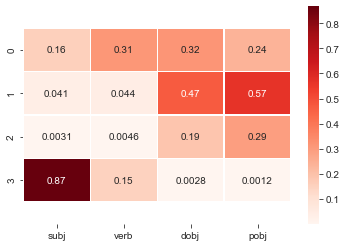

In [186]:

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()
att_df = pd.DataFrame(enc_att)
print(att_df)
sns_plot = show_df_hm2(att_df)
sns_plot.savefig("enc_att.eps", dpi=100, format='eps')

In [165]:

# for i, batch in enumerate(data.val_iter):
#     text_sents = [' '.join([model.index[model.generated_v].itos[w] 
#                             for w in s]).replace(' <pad>', '').replace(' <eos>', '')
#                   for s in batch.text[:, 1:]]
#     # Getting relations' positions
#     rel_idx = shallow_dependencies(text_sents)
#     for r, t in zip(rel_idx, text_sents):
#         # if r['idx']['verb'][0] > 10:
#         print(r, t)
#     if i>10: break
lv_scores = []
for lv in range(sum(h_params.n_latents)):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for att, rel_pos in zip(att_maxes, rel_idx):
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(att[lv] in rel_pos[k])
    lv_scores.append(found)

baseline = []
for k in ['subj', 'verb', 'dobj', 'pobj']:
    all_pos = []
    for pos in rel_idx:
        all_pos.extend(pos[k])
    baseline.append(np.median(all_pos))
print(baseline)

baseline_scores = []
for lv in range(4):
    found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
    for rel_pos in rel_idx:
        for k in found.keys():
            if len(rel_pos[k]):
                found[k].append(baseline[lv] in rel_pos[k])
    baseline_scores.append(found)
            

# found = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
# for att, rel_pos in zip(att_maxes, rel_idx):
#     for k in found.keys():
#         if len(rel_pos[k]):
#             found[k].append(att[lv][layer] in rel_pos[k])


Getting model relationship accuracy:   0%|          | 0/417 [00:00<?, ?it/s]

Getting model relationship accuracy:   0%|          | 2/417 [00:00<00:22, 18.74it/s]

Getting model relationship accuracy:   1%|          | 5/417 [00:00<00:20, 19.72it/s]

Getting model relationship accuracy:   2%|▏         | 8/417 [00:00<00:19, 21.29it/s]

Getting model relationship accuracy:   3%|▎         | 11/417 [00:00<00:18, 22.45it/s]

Getting model relationship accuracy:   3%|▎         | 14/417 [00:00<00:17, 23.17it/s]

Getting model relationship accuracy:   4%|▍         | 17/417 [00:00<00:16, 23.77it/s]

Getting model relationship accuracy:   5%|▍         | 20/417 [00:00<00:16, 23.36it/s]

Getting model relationship accuracy:   6%|▌         | 23/417 [00:00<00:16, 24.07it/s]

Getting model relationship accuracy:   6%|▌         | 26/417 [00:01<00:15, 24.48it/s]

Getting model relationship accuracy:   7%|▋         | 29/417 [00:01<00:16, 23.01it/s]

Getting model relationship accuracy:   8%|▊         | 32/417 [00:01<00:16, 23.70it/s]

Getting model relationship accuracy:   8%|▊         | 35/417 [00:01<00:16, 22.94it/s]

Getting model relationship accuracy:   9%|▉         | 38/417 [00:01<00:16, 22.58it/s]

Getting model relationship accuracy:  10%|▉         | 41/417 [00:01<00:16, 22.34it/s]

Getting model relationship accuracy:  11%|█         | 44/417 [00:01<00:16, 22.37it/s]

Getting model relationship accuracy:  11%|█▏        | 47/417 [00:02<00:15, 23.39it/s]

Getting model relationship accuracy:  12%|█▏        | 50/417 [00:02<00:15, 23.59it/s]

Getting model relationship accuracy:  13%|█▎        | 53/417 [00:02<00:15, 23.13it/s]

Getting model relationship accuracy:  13%|█▎        | 56/417 [00:02<00:16, 21.96it/s]

Getting model relationship accuracy:  14%|█▍        | 59/417 [00:02<00:15, 22.61it/s]

Getting model relationship accuracy:  15%|█▍        | 62/417 [00:02<00:16, 21.49it/s]

Getting model relationship accuracy:  16%|█▌        | 65/417 [00:02<00:16, 21.17it/s]

Getting model relationship accuracy:  16%|█▋        | 68/417 [00:02<00:16, 21.59it/s]

Getting model relationship accuracy:  17%|█▋        | 71/417 [00:03<00:15, 22.32it/s]

Getting model relationship accuracy:  18%|█▊        | 74/417 [00:03<00:14, 23.30it/s]

Getting model relationship accuracy:  18%|█▊        | 77/417 [00:03<00:14, 23.80it/s]

Getting model relationship accuracy:  19%|█▉        | 80/417 [00:03<00:13, 24.46it/s]

Getting model relationship accuracy:  20%|█▉        | 83/417 [00:03<00:13, 24.05it/s]

Getting model relationship accuracy:  21%|██        | 86/417 [00:03<00:13, 23.83it/s]

Getting model relationship accuracy:  21%|██▏       | 89/417 [00:03<00:14, 23.39it/s]

Getting model relationship accuracy:  22%|██▏       | 92/417 [00:03<00:13, 23.76it/s]

Getting model relationship accuracy:  23%|██▎       | 95/417 [00:04<00:13, 24.31it/s]

Getting model relationship accuracy:  24%|██▎       | 98/417 [00:04<00:13, 24.30it/s]

Getting model relationship accuracy:  24%|██▍       | 101/417 [00:04<00:13, 23.99it/s]

Getting model relationship accuracy:  25%|██▍       | 104/417 [00:04<00:13, 23.96it/s]

Getting model relationship accuracy:  26%|██▌       | 107/417 [00:04<00:12, 24.40it/s]

Getting model relationship accuracy:  26%|██▋       | 110/417 [00:04<00:12, 24.24it/s]

Getting model relationship accuracy:  27%|██▋       | 113/417 [00:04<00:12, 24.30it/s]

Getting model relationship accuracy:  28%|██▊       | 116/417 [00:04<00:12, 25.02it/s]

Getting model relationship accuracy:  29%|██▊       | 119/417 [00:05<00:11, 25.48it/s]

Getting model relationship accuracy:  29%|██▉       | 122/417 [00:05<00:11, 26.01it/s]

Getting model relationship accuracy:  30%|██▉       | 125/417 [00:05<00:11, 26.33it/s]

Getting model relationship accuracy:  31%|███       | 128/417 [00:05<00:10, 26.48it/s]

Getting model relationship accuracy:  31%|███▏      | 131/417 [00:05<00:10, 26.81it/s]

Getting model relationship accuracy:  32%|███▏      | 134/417 [00:05<00:10, 26.82it/s]

Getting model relationship accuracy:  33%|███▎      | 137/417 [00:05<00:10, 26.98it/s]

Getting model relationship accuracy:  34%|███▎      | 140/417 [00:05<00:10, 27.01it/s]

Getting model relationship accuracy:  34%|███▍      | 143/417 [00:05<00:10, 26.54it/s]

Getting model relationship accuracy:  35%|███▌      | 146/417 [00:06<00:10, 25.55it/s]

Getting model relationship accuracy:  36%|███▌      | 149/417 [00:06<00:10, 24.71it/s]

Getting model relationship accuracy:  36%|███▋      | 152/417 [00:06<00:10, 25.32it/s]

Getting model relationship accuracy:  37%|███▋      | 155/417 [00:06<00:10, 25.56it/s]

Getting model relationship accuracy:  38%|███▊      | 158/417 [00:06<00:10, 24.91it/s]

Getting model relationship accuracy:  39%|███▊      | 161/417 [00:07<00:28,  8.85it/s]

Getting model relationship accuracy:  39%|███▉      | 164/417 [00:07<00:23, 10.89it/s]

Getting model relationship accuracy:  40%|████      | 167/417 [00:07<00:19, 13.15it/s]

Getting model relationship accuracy:  41%|████      | 170/417 [00:07<00:16, 15.41it/s]

Getting model relationship accuracy:  41%|████▏     | 173/417 [00:07<00:14, 17.42it/s]

Getting model relationship accuracy:  42%|████▏     | 176/417 [00:08<00:12, 19.33it/s]

Getting model relationship accuracy:  43%|████▎     | 179/417 [00:08<00:11, 21.10it/s]

Getting model relationship accuracy:  44%|████▎     | 182/417 [00:08<00:10, 22.65it/s]

Getting model relationship accuracy:  44%|████▍     | 185/417 [00:08<00:09, 23.94it/s]

Getting model relationship accuracy:  45%|████▌     | 188/417 [00:08<00:09, 24.75it/s]

Getting model relationship accuracy:  46%|████▌     | 191/417 [00:08<00:08, 25.22it/s]

Getting model relationship accuracy:  47%|████▋     | 194/417 [00:08<00:08, 25.89it/s]

Getting model relationship accuracy:  47%|████▋     | 197/417 [00:08<00:08, 25.83it/s]

Getting model relationship accuracy:  48%|████▊     | 200/417 [00:08<00:08, 25.93it/s]

Getting model relationship accuracy:  49%|████▊     | 203/417 [00:09<00:08, 26.00it/s]

Getting model relationship accuracy:  49%|████▉     | 206/417 [00:09<00:08, 26.11it/s]

Getting model relationship accuracy:  50%|█████     | 209/417 [00:09<00:08, 25.14it/s]

Getting model relationship accuracy:  51%|█████     | 212/417 [00:09<00:08, 24.81it/s]

Getting model relationship accuracy:  52%|█████▏    | 215/417 [00:09<00:08, 24.58it/s]

Getting model relationship accuracy:  52%|█████▏    | 218/417 [00:09<00:07, 25.22it/s]

Getting model relationship accuracy:  53%|█████▎    | 221/417 [00:09<00:07, 25.30it/s]

Getting model relationship accuracy:  54%|█████▎    | 224/417 [00:09<00:07, 25.62it/s]

Getting model relationship accuracy:  54%|█████▍    | 227/417 [00:09<00:07, 25.71it/s]

Getting model relationship accuracy:  55%|█████▌    | 230/417 [00:10<00:07, 24.10it/s]

Getting model relationship accuracy:  56%|█████▌    | 233/417 [00:10<00:07, 24.03it/s]

Getting model relationship accuracy:  57%|█████▋    | 236/417 [00:10<00:07, 23.10it/s]

Getting model relationship accuracy:  57%|█████▋    | 239/417 [00:10<00:08, 22.09it/s]

Getting model relationship accuracy:  58%|█████▊    | 242/417 [00:10<00:07, 22.25it/s]

Getting model relationship accuracy:  59%|█████▉    | 245/417 [00:10<00:07, 23.02it/s]

Getting model relationship accuracy:  59%|█████▉    | 248/417 [00:10<00:07, 22.90it/s]

Getting model relationship accuracy:  60%|██████    | 251/417 [00:11<00:06, 23.85it/s]

Getting model relationship accuracy:  61%|██████    | 254/417 [00:11<00:06, 23.41it/s]

Getting model relationship accuracy:  62%|██████▏   | 257/417 [00:11<00:06, 23.11it/s]

Getting model relationship accuracy:  62%|██████▏   | 260/417 [00:11<00:06, 23.07it/s]

Getting model relationship accuracy:  63%|██████▎   | 263/417 [00:11<00:06, 23.09it/s]

Getting model relationship accuracy:  64%|██████▍   | 266/417 [00:11<00:06, 22.79it/s]

Getting model relationship accuracy:  65%|██████▍   | 269/417 [00:11<00:06, 23.00it/s]

Getting model relationship accuracy:  65%|██████▌   | 272/417 [00:11<00:06, 22.47it/s]

Getting model relationship accuracy:  66%|██████▌   | 275/417 [00:12<00:06, 23.19it/s]

Getting model relationship accuracy:  67%|██████▋   | 278/417 [00:12<00:06, 22.45it/s]

Getting model relationship accuracy:  67%|██████▋   | 281/417 [00:12<00:06, 21.40it/s]

Getting model relationship accuracy:  68%|██████▊   | 284/417 [00:12<00:06, 20.97it/s]

Getting model relationship accuracy:  69%|██████▉   | 287/417 [00:12<00:06, 20.65it/s]

Getting model relationship accuracy:  70%|██████▉   | 290/417 [00:12<00:05, 21.20it/s]

Getting model relationship accuracy:  70%|███████   | 293/417 [00:12<00:05, 21.99it/s]

Getting model relationship accuracy:  71%|███████   | 296/417 [00:13<00:05, 22.83it/s]

Getting model relationship accuracy:  72%|███████▏  | 299/417 [00:13<00:05, 23.18it/s]

Getting model relationship accuracy:  72%|███████▏  | 302/417 [00:13<00:04, 23.78it/s]

Getting model relationship accuracy:  73%|███████▎  | 305/417 [00:13<00:04, 23.25it/s]

Getting model relationship accuracy:  74%|███████▍  | 308/417 [00:13<00:04, 23.22it/s]

Getting model relationship accuracy:  75%|███████▍  | 311/417 [00:13<00:04, 23.41it/s]

Getting model relationship accuracy:  75%|███████▌  | 314/417 [00:13<00:04, 23.77it/s]

Getting model relationship accuracy:  76%|███████▌  | 317/417 [00:13<00:04, 23.92it/s]

Getting model relationship accuracy:  77%|███████▋  | 320/417 [00:14<00:04, 23.90it/s]

Getting model relationship accuracy:  77%|███████▋  | 323/417 [00:14<00:03, 24.54it/s]

Getting model relationship accuracy:  78%|███████▊  | 326/417 [00:14<00:03, 25.19it/s]

Getting model relationship accuracy:  79%|███████▉  | 329/417 [00:14<00:03, 25.73it/s]

Getting model relationship accuracy:  80%|███████▉  | 332/417 [00:14<00:03, 26.13it/s]

Getting model relationship accuracy:  80%|████████  | 335/417 [00:14<00:03, 26.48it/s]

Getting model relationship accuracy:  81%|████████  | 338/417 [00:14<00:02, 26.45it/s]

Getting model relationship accuracy:  82%|████████▏ | 341/417 [00:14<00:02, 26.43it/s]

Getting model relationship accuracy:  82%|████████▏ | 344/417 [00:14<00:02, 26.35it/s]

Getting model relationship accuracy:  83%|████████▎ | 347/417 [00:15<00:02, 26.57it/s]

Getting model relationship accuracy:  84%|████████▍ | 350/417 [00:15<00:02, 26.87it/s]

Getting model relationship accuracy:  85%|████████▍ | 353/417 [00:15<00:02, 26.65it/s]

Getting model relationship accuracy:  85%|████████▌ | 356/417 [00:15<00:02, 26.02it/s]

Getting model relationship accuracy:  86%|████████▌ | 359/417 [00:15<00:02, 26.27it/s]

Getting model relationship accuracy:  87%|████████▋ | 362/417 [00:15<00:02, 25.83it/s]

Getting model relationship accuracy:  88%|████████▊ | 365/417 [00:15<00:01, 26.13it/s]

Getting model relationship accuracy:  88%|████████▊ | 368/417 [00:15<00:01, 26.27it/s]

Getting model relationship accuracy:  89%|████████▉ | 371/417 [00:15<00:01, 26.52it/s]

Getting model relationship accuracy:  90%|████████▉ | 374/417 [00:16<00:01, 26.55it/s]

Getting model relationship accuracy:  90%|█████████ | 377/417 [00:16<00:01, 26.50it/s]

Getting model relationship accuracy:  91%|█████████ | 380/417 [00:16<00:01, 26.75it/s]

Getting model relationship accuracy:  92%|█████████▏| 383/417 [00:16<00:01, 26.78it/s]

Getting model relationship accuracy:  93%|█████████▎| 386/417 [00:16<00:01, 26.95it/s]

Getting model relationship accuracy:  93%|█████████▎| 389/417 [00:16<00:01, 26.99it/s]

Getting model relationship accuracy:  94%|█████████▍| 392/417 [00:16<00:00, 27.10it/s]

Getting model relationship accuracy:  95%|█████████▍| 395/417 [00:16<00:00, 26.95it/s]

Getting model relationship accuracy:  95%|█████████▌| 398/417 [00:16<00:00, 26.92it/s]

Getting model relationship accuracy:  96%|█████████▌| 401/417 [00:17<00:00, 26.69it/s]

Getting model relationship accuracy:  97%|█████████▋| 404/417 [00:17<00:00, 26.53it/s]

Getting model relationship accuracy:  98%|█████████▊| 407/417 [00:17<00:00, 26.63it/s]

Getting model relationship accuracy:  98%|█████████▊| 410/417 [00:17<00:00, 26.69it/s]

Getting model relationship accuracy:  99%|█████████▉| 413/417 [00:17<00:00, 26.67it/s]

Getting model relationship accuracy: 100%|█████████▉| 416/417 [00:17<00:00, 26.66it/s]

Getting model relationship accuracy: 100%|██████████| 417/417 [00:17<00:00, 23.57it/s]

==== Final Model Scores =======
{'subj': 0.8672220775839625, 'verb': 0.314611233260044, 'dobj': 0.4699812382739212, 'pobj': 0.5666666666666667}
{'subj': 0.7073678729497527, 'verb': 0.1643014191485109, 'dobj': 0.15384615384615385, 'pobj': 0.2719135802469136}
{'subj': 3, 'verb': 0, 'dobj': 1, 'pobj': 1}


In [167]:
print("========our Model ========")
Enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(sum(h_params.n_latents)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in lv_scores[lv].items()})
        for k, v in lv_scores[lv].items():
            Enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in Enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score)
print(enc_disent_vars)
print("========our baseline ========")

baseline_enc_att_scores = {'subj':[], 'verb':[], 'dobj':[], 'pobj':[]}
for lv in range(sum(h_params.n_latents)):
    for layer in range(1):#h_params.encoder_l):
        print("Scores for lv {}, layer {}:".format(lv, layer))
        print({k:np.mean(v)for k, v in baseline_scores[lv].items()})
        for k, v in baseline_scores[lv].items():
            baseline_enc_att_scores[k].append(np.mean(v))
print("==== Final Scores =======")
enc_max_score = {}
enc_disent_score = {}
enc_disent_vars = {}
for k, v in baseline_enc_att_scores.items():
    sort_idx = np.argsort(v) 
    enc_disent_vars[k] = sort_idx[-1]
    enc_disent_score[k] = v[sort_idx[-1]] - v[sort_idx[-2]]
    enc_max_score[k] = v[sort_idx[-1]]
print(enc_max_score)
print(enc_disent_score)
print(enc_disent_vars)

========our Model ========
Scores for lv 0, layer 0:
{'subj': 0.15490757615204373, 'verb': 0.31960823505896463, 'dobj': 0.3058161350844278, 'pobj': 0.22777777777777777}
Scores for lv 1, layer 0:
{'subj': 0.03827128351991669, 'verb': 0.04797121726963822, 'dobj': 0.44934333958724204, 'pobj': 0.5645061728395062}
Scores for lv 2, layer 0:
{'subj': 0.0036448841447539702, 'verb': 0.005996402158704777, 'dobj': 0.19277673545966229, 'pobj': 0.3021604938271605}
Scores for lv 3, layer 0:
{'subj': 0.8646185889091382, 'verb': 0.15630621627023786, 'dobj': 0.00046904315196998124, 'pobj': 0.0015432098765432098}
==== Final Scores =======
{'subj': 0.8646185889091382, 'verb': 0.31960823505896463, 'dobj': 0.44934333958724204, 'pobj': 0.5645061728395062}
{'subj': 0.7097110127570945, 'verb': 0.16330201878872677, 'dobj': 0.14352720450281425, 'pobj': 0.26234567901234573}
{'subj': 3, 'verb': 0, 'dobj': 1, 'pobj': 1}
========our baseline ========
Scores for lv 0, layer 0:
{'subj': 0.8838844051028378, 'verb': 0.

[{'subj': 'A man in a yellow jacket', 'verb': 'is going', 'np': '', 'pp': ' to the beach'}, {'subj': 'a man', 'verb': 'is running', 'np': '', 'pp': ' on a beach'}]
((True, False), (True, False), (False, False), (True, False), True, False)


dict_keys(['class_probabilities', 'spans', 'tokens', 'pos_tags', 'num_spans', 'hierplane_tree', 'trees'])


[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [7, 7], [7, 8], [7, 9], [7, 10], [8, 8], [8, 9], [8, 10], [9, 9], [9, 10], [10, 10]]
['A', 'man', 'in', 'a', 'yellow', 'jacket', 'is', 'going', 'to', 'the', 'beach']
(S (NP (NP (DT A) (NN man)) (PP (IN in) (NP (DT a) (JJ yellow) (NN jacket)))) (VP (VBZ is) (VP (VBG going) (PP (IN to) (NP (DT the) (NN beach))))))


[['a man in a yellow jacket', [0, 1, 2, 3, 4, 5]]] ['throwing', [7]] [['a ball and a towel in the beach', [8, 9, 10, 11, 12, 13, 14, 15]]] [['a yellow jacket', [3, 4, 5]]]


[['a man in a yellow jacket', [0, 1, 2, 3, 4, 5]]] ['throwing', [7]] [['a ball and a towel in the beach', [8, 9, 10, 11, 12, 13, 14, 15]]] [['a yellow jacket', [3, 4, 5]]]


[['a man in a yellow jacket', [0, 1, 2, 3, 4, 5]]] ['throwing', [7]] [['a ball and a towel in the beach', [8, 9, 10, 11, 12, 13, 14, 15]]] [['a yellow jacket', [3, 4, 5]]]
